# Different deep learning approaches for speech command recognition: attention mechanisms, residual connections, and a transformer’s encoder
### Camilo Betancourt Nieto
Final project for the Deep Learning and Human Data Analytics subject at the University of Padova

## Preliminary steps

In [ ]:
!pip install tensorflow==2.15.0

In [ ]:
!pip install -q tensorflow tensorflow_datasets

In [ ]:
!pip install -q pydub

In [ ]:
!pip install -q python_speech_features

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q speechpy

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
import time
import pickle
import json
import math
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from IPython import display

from python_speech_features import mfcc
from python_speech_features import logfbank
from speechpy import processing as sp_processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd 'drive/MyDrive/Unipd/HDA_labs/Project'

/content/drive/MyDrive/Unipd/HDA_labs/Project


In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
path_plots = 'Plots/'
path_cache = 'Cache/'
path_models = 'Models/'
path_others = 'Others/'

In [ ]:
# Setting the seed value for experiment reproducibility.
seed = 111
tf.random.set_seed(seed)
np.random.seed(seed)

## Data loading and preprocessing

### Loading the data

First, load the Speech Commands data from the TensorFlow repository as supervised -as a tuple with the format (features, label)-.

In [ ]:
sc_data, sc_info = tfds.load('speech_commands', split=['train','validation','test'], as_supervised=True, with_info=True)
sc_train, sc_val, sc_test = sc_data[0],sc_data[1], sc_data[2]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/85511 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/0.0.3.incompleteR1PGTA/speech_commands-train.tfrecord*...:…

Generating validation examples...:   0%|          | 0/10102 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/0.0.3.incompleteR1PGTA/speech_commands-validation.tfrecord…

Generating test examples...:   0%|          | 0/4890 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/0.0.3.incompleteR1PGTA/speech_commands-test.tfrecord*...: …

Dataset speech_commands downloaded and prepared to /root/tensorflow_datasets/speech_commands/0.0.3. Subsequent calls will reuse this data.


In [ ]:
sc_info

tfds.core.DatasetInfo(
    name='speech_commands',
    full_name='speech_commands/0.0.3',
    description="""
    An audio dataset of spoken words designed to help train and evaluate keyword
    spotting systems. Its primary goal is to provide a way to build and test small
    models that detect when a single word is spoken, from a set of ten target words,
    with as few false positives as possible from background noise or unrelated
    speech. Note that in the train and validation set, the label "unknown" is much
    more prevalent than the labels of the target words or background noise. One
    difference from the release version is the handling of silent segments. While in
    the test set the silence segments are regular 1 second files, in the training
    they are provided as long segments under "background_noise" folder. Here we
    split these background noise into 1 second clips, and also keep one of the files
    for the validation set.
    """,
    homepage='https://arxiv.or

In [ ]:
label_names=sc_info.features['label'].names
n_categories = len(label_names)
print(label_names)

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']


In [ ]:
# Getting the structure of the dataset
for example in sc_train.take(10):
  print(example)

(<tf.Tensor: shape=(16000,), dtype=int16, numpy=array([-15, -18, -12, ...,  16,  21,  25], dtype=int16)>, <tf.Tensor: shape=(), dtype=int64, numpy=4>)
(<tf.Tensor: shape=(16000,), dtype=int16, numpy=array([  75,   29,  -85, ..., -343,  304,  879], dtype=int16)>, <tf.Tensor: shape=(), dtype=int64, numpy=5>)
(<tf.Tensor: shape=(16000,), dtype=int16, numpy=array([0, 0, 2, ..., 2, 1, 1], dtype=int16)>, <tf.Tensor: shape=(), dtype=int64, numpy=7>)
(<tf.Tensor: shape=(16000,), dtype=int16, numpy=array([ 1, 15, 13, ..., 29, 34, 14], dtype=int16)>, <tf.Tensor: shape=(), dtype=int64, numpy=5>)
(<tf.Tensor: shape=(16000,), dtype=int16, numpy=array([ 0,  0,  0, ...,  1, -1,  2], dtype=int16)>, <tf.Tensor: shape=(), dtype=int64, numpy=7>)
(<tf.Tensor: shape=(12456,), dtype=int16, numpy=array([  0,   0,   0, ..., -22, -59, -24], dtype=int16)>, <tf.Tensor: shape=(), dtype=int64, numpy=2>)
(<tf.Tensor: shape=(12632,), dtype=int16, numpy=array([  45,   82,   40, ..., -352, -371, -307], dtype=int16)>, 

Plotting some examples

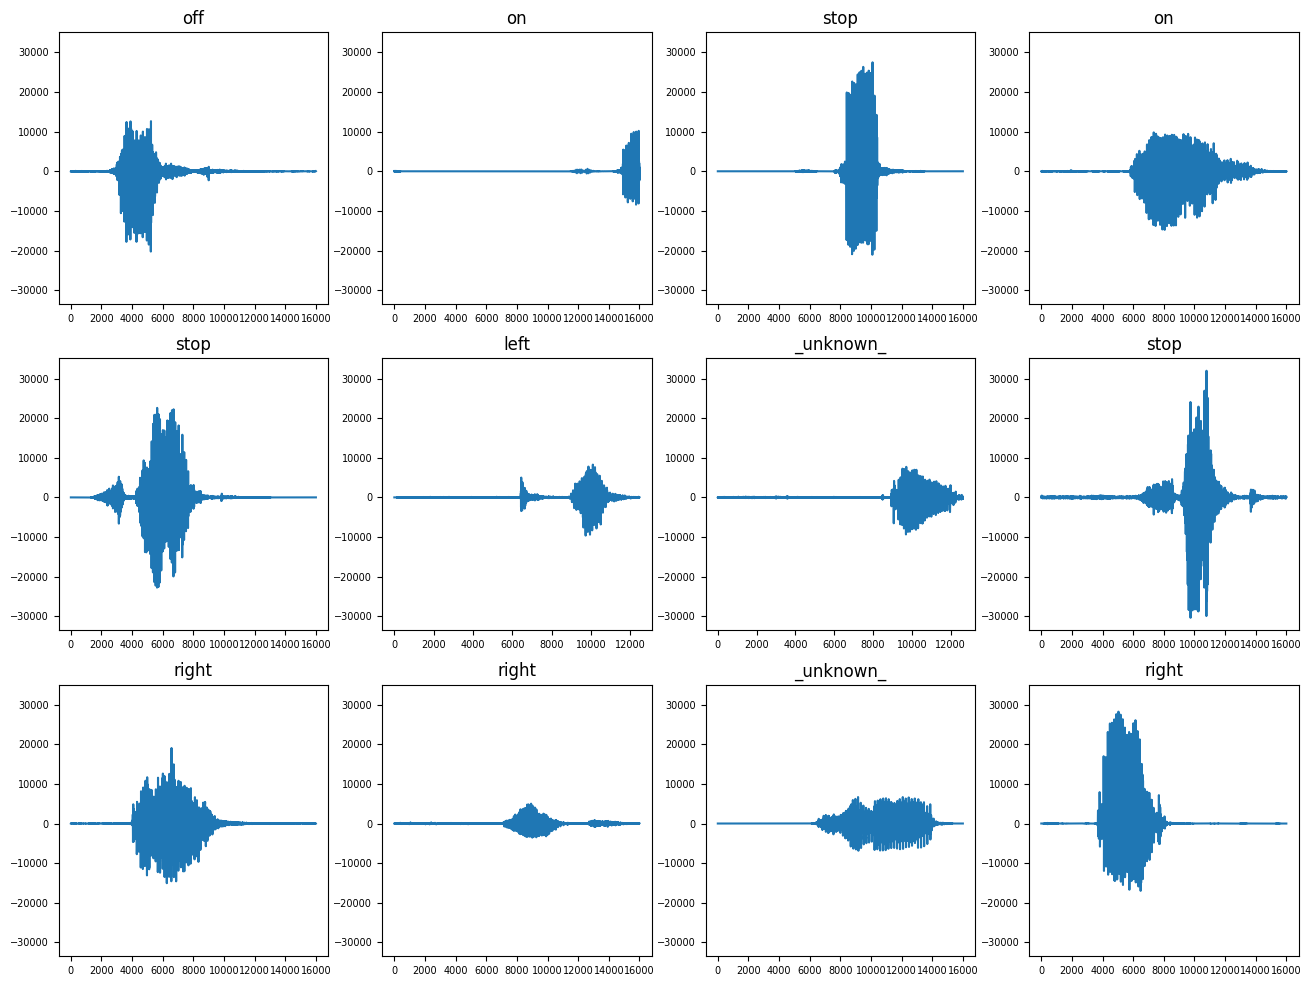

In [ ]:
def plot_audios(dataset=sc_train, n_rows=3,n_cols=4, save_path=None):
  plt.figure(figsize=(4*n_cols, 4*n_rows))
  n = n_rows * n_cols

  n_examples = dataset.take(n)
  for i, example in enumerate(n_examples):
    audio, label = example

    # Plotting each example with the scaling corresponding to the first observation
    if i ==0:
      ax_1 = plt.subplot(n_rows, n_cols, i+1)
    else:
      ax_i = plt.subplot(n_rows, n_cols, i+1, sharey=ax_1)
    plt.plot(audio)
    plt.title(label_names[label])

    plt.tick_params(axis='both', labelsize=7)

    if save_path:
        plt.savefig(save_path)

plot_audios()

This is just to take one specific example as reference for the processing steps:

In [ ]:
id_example_plots = 5

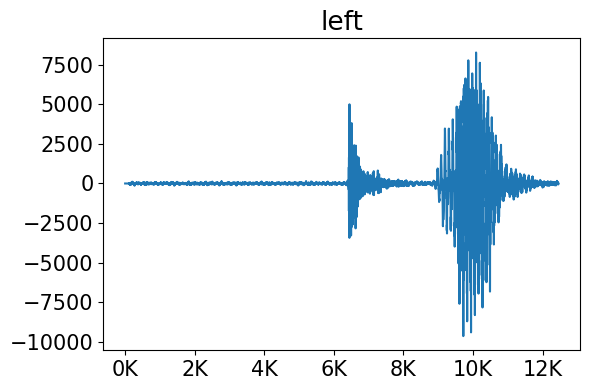

In [ ]:
# Function to format the thousands as "K"
def thousands_formatter(x, pos):
    return '%1.0fK' % (x * 1e-3)

def plot_specific_audio(dataset, index_example=id_example_plots, save_path=None):
  example = dataset.skip(index_example).take(1)
  for audio, label in example:
    plt.figure(figsize=(6, 4))
    plt.plot(audio)
    plt.title(label_names[label], fontsize=19)

    # Setting tick parameters with specified font size
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    # Formatting the thousands as "K"
    ax = plt.gca()
    ax.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))

    if save_path:
      plt.tight_layout()
      plt.savefig(save_path)

plot_specific_audio(dataset=sc_train)

In [ ]:
def listen_example(dataset, index_example=0):
  example = dataset.skip(index_example).take(1)
  for audio, label in example:
    display.display(display.Audio(audio, rate=16000))
listen_example(sc_train, id_example_plots)

Hearing also to a particular example from the "\_silence_" category, which only contain background noise.

In [ ]:
# Filter examples with label "_silence_" (label number 10)
silence_audios = sc_train.filter(lambda audio, label: label == 10)

# Listen to an example from the _silence_ category
listen_example(silence_audios)

### Data preprocessing

#### Padding

As seen in the previous section, some samples are incomplete, so they need to be padded.

In [ ]:
def pad_audio(audio, label):
    padded_audio = tf.pad(audio, paddings=[[0, 16000 - tf.shape(audio)[0]]], mode='CONSTANT', constant_values=0)
    return (padded_audio, label)

# Checking the first few examples to verify the padding
print('Before padding:')
for example in sc_train.take(10):
    print(example)

print('\nAfter padding:')
padded_examples = sc_train.map(pad_audio)
for example in padded_examples.take(10):
    print(example)

Before padding:
(<tf.Tensor: shape=(16000,), dtype=int16, numpy=array([-15, -18, -12, ...,  16,  21,  25], dtype=int16)>, <tf.Tensor: shape=(), dtype=int64, numpy=4>)
(<tf.Tensor: shape=(16000,), dtype=int16, numpy=array([  75,   29,  -85, ..., -343,  304,  879], dtype=int16)>, <tf.Tensor: shape=(), dtype=int64, numpy=5>)
(<tf.Tensor: shape=(16000,), dtype=int16, numpy=array([0, 0, 2, ..., 2, 1, 1], dtype=int16)>, <tf.Tensor: shape=(), dtype=int64, numpy=7>)
(<tf.Tensor: shape=(16000,), dtype=int16, numpy=array([ 1, 15, 13, ..., 29, 34, 14], dtype=int16)>, <tf.Tensor: shape=(), dtype=int64, numpy=5>)
(<tf.Tensor: shape=(16000,), dtype=int16, numpy=array([ 0,  0,  0, ...,  1, -1,  2], dtype=int16)>, <tf.Tensor: shape=(), dtype=int64, numpy=7>)
(<tf.Tensor: shape=(12456,), dtype=int16, numpy=array([  0,   0,   0, ..., -22, -59, -24], dtype=int16)>, <tf.Tensor: shape=(), dtype=int64, numpy=2>)
(<tf.Tensor: shape=(12632,), dtype=int16, numpy=array([  45,   82,   40, ..., -352, -371, -307],

#### Audio normalization

The raw audio signals should be normalized. in this case, I will use a z-score approach across samples (instead of using a per-sample normalization). The reason for this is that it aims to maintain a balanced level among examples and avoids quiet samples (eg. the background noise) to become excessively loud and noisy.

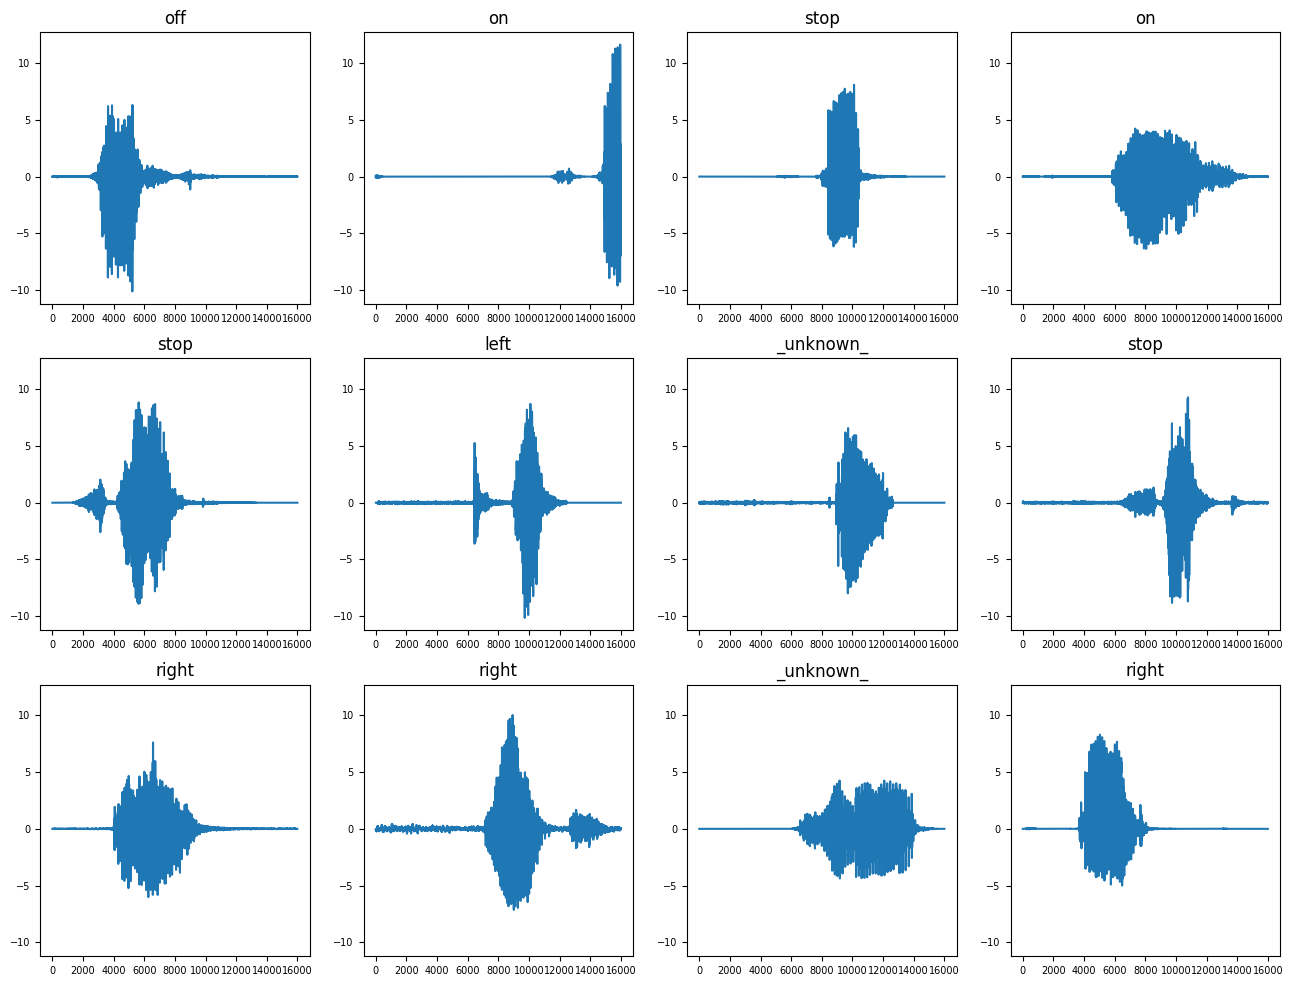

In [ ]:
def normalize_audio(audio, label):
  audio_float = tf.cast(audio, tf.float32)
  mean = tf.math.reduce_mean(audio_float)
  std_dev = tf.math.reduce_std(audio_float)
  normalized_audio = (audio_float - mean) / std_dev
  return (normalized_audio, label)

# Checking the first few examples to verify the normalization
audio_norm_examples = padded_examples.map(normalize_audio)

plot_audios(audio_norm_examples)

#### Obtaining the MFCCs

In [ ]:
# TensorFlow expects float32 data, so it is necessary to convert the output of mfcc (that would be float 64 otherwise)

# The computation is made with the default parameters, which already select the 12 features and add the energy.
def mfcc_32_bit(audio):
  return mfcc(audio).astype(np.float32)

# tf.numpy_function is used to include arbitrary python functions inside the TensorFlow graph.
tf_mfcc = lambda audio, label: (tf.numpy_function(mfcc_32_bit, [audio], tf.float32), label)
mfcc_examples = audio_norm_examples.map(tf_mfcc, num_parallel_calls=os.cpu_count())


MFCCs structrue:
tf.Tensor(
[[ -3.3196359  -6.3736725 -20.863276  ...  -3.6233833   4.0899787
   -9.883004 ]
 [ -2.9894757  -6.077453  -20.850367  ...  -5.2072015   7.094192
   -2.8389335]
 [ -2.7886984  -8.239738  -28.940928  ... -14.24155     8.806277
   -3.2290585]
 ...
 [-15.409273   19.944633   12.418071  ...   5.0518675   3.9080226
    2.835003 ]
 [-15.409273   19.944633   12.418071  ...   5.0518675   3.9080226
    2.835003 ]
 [-15.724224   20.160416   12.745505  ...   5.2430634   4.1394463
    3.175857 ]], shape=(99, 13), dtype=float32)


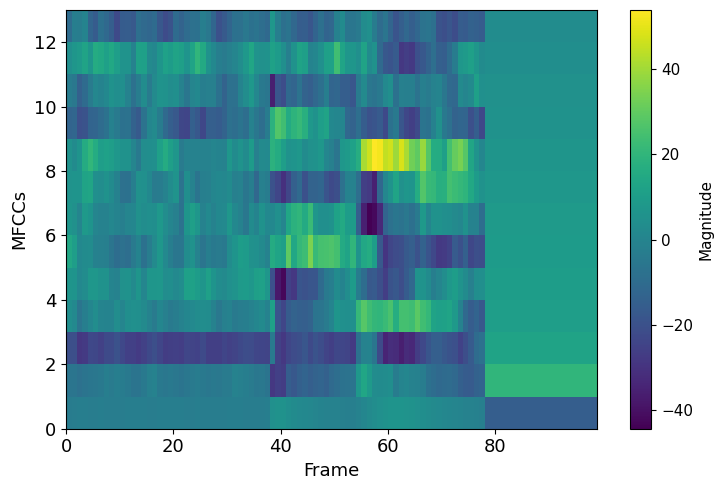

In [ ]:
# Plotting and example and showing the structure of the data
def plot_matrix(dataset, index_example=id_example_plots, y_label='MFCCs', x_label='Frame',
                verbose=False, save_path=None):
  example = dataset.skip(index_example).take(1)
  for matrix, label in example:
    matrix_numpy = matrix.numpy()
    plt.figure(figsize=(7.5, 5))
    plt.pcolormesh(matrix_numpy.T, cmap='viridis')
    plt.xlabel(x_label, fontsize=13)
    plt.ylabel(y_label, fontsize=13)
    cbar = plt.colorbar()

    # Setting tick parameters with specified font size
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    cbar.ax.tick_params(labelsize=11)
    cbar.set_label('Magnitude', fontsize=11)

  if verbose:
    print('\n' + y_label + ' structrue:')
    print(matrix)

  if save_path:
    plt.tight_layout()
    plt.savefig(save_path)

plot_matrix(mfcc_examples, verbose=True)

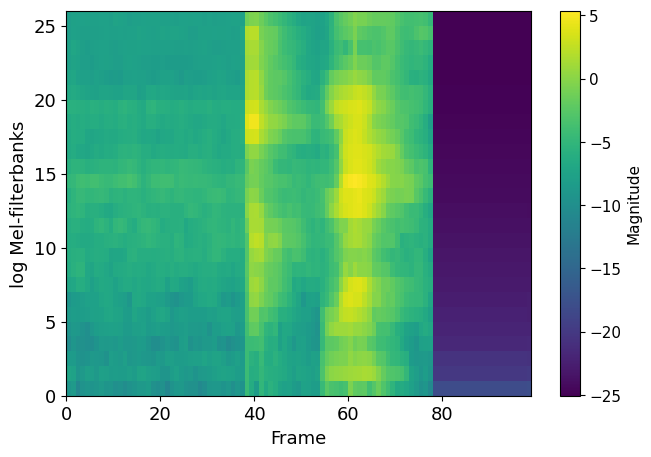

In [ ]:
# The log-filterbanks are also computed just for visualization
def logmelbanks_32_bit(audio):
  return logfbank(audio).astype(np.float32)

py_logmelbanks = lambda audio, label: (tf.numpy_function(logmelbanks_32_bit, [audio], tf.float32), label)
logmelbanks_examples = audio_norm_examples.map(py_logmelbanks, num_parallel_calls=os.cpu_count())

plot_matrix(logmelbanks_examples, y_label='log Mel-filterbanks')

The computation with the library is working well since, as expected, the log Mel-filterbank features align with the parts that contain information.

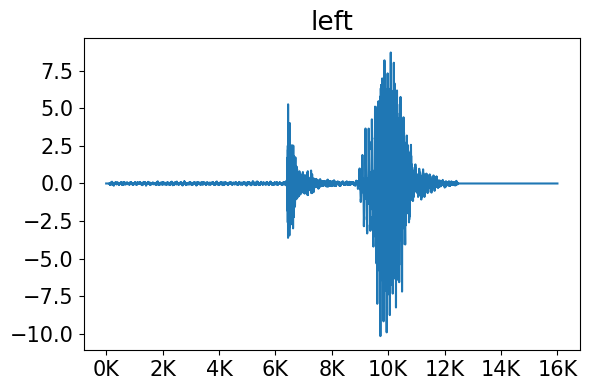

In [ ]:
plot_specific_audio(dataset=audio_norm_examples)

#### Normalizing the MFCCs

Now, to pass the models a normalized input I also apply the Cepstral Mean and Variance Normalization (CMVN). I use a per-sample approach (which takes the mean and variance of each feature across the different frames of each sample).

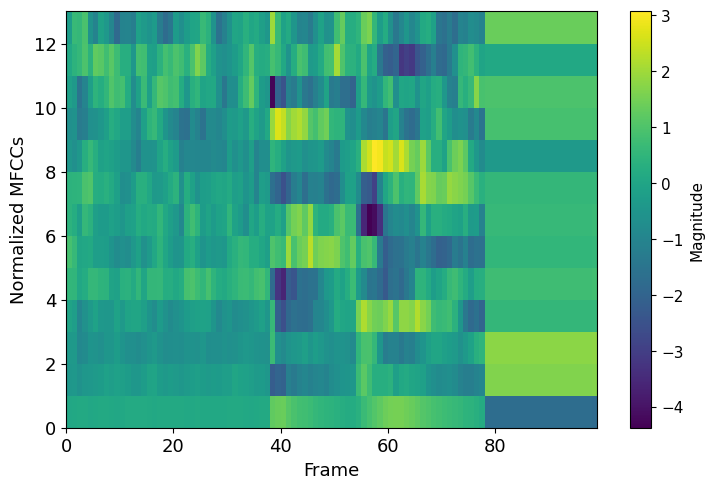

In [ ]:
# TensorFlow expects float32 data, so it is necessary to convert the output of mfcc (that would be float 64 otherwise)
def cmvn_32_bit(features):
  return sp_processing.cmvn(features, variance_normalization=True).astype(np.float32)

# tf.numpy_function is used to include arbitrary python functions inside the TensorFlow graph.
tf_cmvn = lambda features, label: (tf.numpy_function(cmvn_32_bit, [features], tf.float32), label)
mfcc_norm_examples = mfcc_examples.map(tf_cmvn, num_parallel_calls=os.cpu_count())

plot_matrix(mfcc_norm_examples, y_label='Normalized MFCCs')

#### Wrapping all preprocessing steps

Organizing all the preprocessing steps in a single function. It also adjusts the input dimension for each type of model (RNN or transformer-based). There will be two versions of the datasets:

- RNN models' dataset (the default one, labelled as "__processed"): adds an empty axis in the end so that
the input data is structured as (batch, seq_len, features, channels). In this case, seq_len is the number of frames of each audio.
- Transformer-based models' dataset (only used for two last models, labelled as "_processed_transf"): it omits the step mentioned above.


In [ ]:
# Old version
def wrap_preprocessing(reference_dataset, batch_size, shuffle, add_axis=True, cache_file=None):
  # All the deterministic processes will be performed before caching

  # Padding the audio
  final_dataset = reference_dataset.map(pad_audio)

  # Normalizing the audio
  final_dataset = final_dataset.map(normalize_audio)

  # Obtaining the MFCCs
  final_dataset = final_dataset.map(tf_mfcc, num_parallel_calls=os.cpu_count())

  # Cepstral Mean and Variance Normalization (CMVN) of the MFCCs
  final_dataset = final_dataset.map(tf_cmvn, num_parallel_calls=os.cpu_count())

  # When using the tf.numpy_function the shape information gets lost and it
  # results in errors when training the transformer-based models, so this is
  # to ensure the shape of the data as (seq_len, features) -that will be interpreted automatically.
  final_dataset = final_dataset.map(lambda data, label: (tf.ensure_shape(data, [None,None]),label))

  # Correct input shape for the network (adds the axis only for the RNN datasets)
  if add_axis:
    final_dataset = final_dataset.map(lambda data, label: (tf.expand_dims(data, -1), label))

  # Caching dataset
  if cache_file:
    final_dataset = final_dataset.cache(cache_file)

  # Shuffling
  if shuffle:
    num_observations = tf.data.experimental.cardinality(final_dataset)
    print(num_observations)
    final_dataset = final_dataset.shuffle(num_observations)

  # Repeating the dataset indefinitely
  final_dataset = final_dataset.repeat()

  # Batching
  final_dataset = final_dataset.batch(batch_size=batch_size)

  # Prefetching
  final_dataset = final_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return final_dataset

Inizialization of the preprocessed datasets. Only the training dataset is shuffled and augmented.

In [ ]:
batch_size = 128

sc_train_processed = wrap_preprocessing(reference_dataset = sc_train,
                                        batch_size = batch_size,
                                        shuffle = True,
                                        cache_file = path_cache + 'train_cache')

sc_val_processed = wrap_preprocessing(reference_dataset = sc_val,
                                      batch_size = batch_size,
                                      shuffle = False,
                                      cache_file = path_cache + 'val_cache')

sc_test_processed = wrap_preprocessing(reference_dataset = sc_test,
                                       batch_size = batch_size,
                                       shuffle = False,
                                       cache_file = path_cache + 'test_cache')

tf.Tensor(85511, shape=(), dtype=int64)


In [ ]:
batch_size = 128

sc_train_processed_transf = wrap_preprocessing(reference_dataset = sc_train,
                                               batch_size = batch_size,
                                               shuffle = True,
                                               add_axis = False,
                                               cache_file = path_cache + 'train_cache_transf')

sc_val_processed_transf = wrap_preprocessing(reference_dataset = sc_val,
                                             batch_size = batch_size,
                                             shuffle = False,
                                             add_axis = False,
                                             cache_file = path_cache + 'val_cache_transf')

sc_test_processed_transf = wrap_preprocessing(reference_dataset = sc_test,
                                              batch_size = batch_size,
                                              shuffle = False,
                                              add_axis = False,
                                              cache_file = path_cache + 'test_cache_transf')

tf.Tensor(85511, shape=(), dtype=int64)


I also evaluate the number of steps (train_steps, val_steps and test_steps) required to load and process the entire dataset (num. of samples / batch_size). These will be used later.

In [ ]:
# The dataset lengths are defined for computing the steps (later)
# The length is computed with the raw datasets because the processed
# ones do not allow to do this easily.

train_length = tf.data.experimental.cardinality(sc_train).numpy()
val_length = tf.data.experimental.cardinality(sc_val).numpy()
test_length = tf.data.experimental.cardinality(sc_test).numpy()

Allowing a smoke test optionallity with just a subset of the data for debugging:

In [ ]:
smoke_test = False

if smoke_test:
  print('Train size before the smoke test reduction: ' + str(train_length))
  print('Val size before the smoke test reduction: ' + str(val_length))
  print('Test size before the smoke test reduction: ' + str(test_length))

  sc_train_processed = sc_train_processed.take(1000)
  sc_val_processed = sc_train_processed.take(100)
  sc_test_processed = sc_train_processed.take(100)

  # Recomputing the lengths
  train_length = tf.data.experimental.cardinality(sc_train_processed).numpy()
  val_length = tf.data.experimental.cardinality(sc_val_processed).numpy()
  test_length = tf.data.experimental.cardinality(sc_test_processed).numpy()

  print('\nTrain size after the smoke test reduction: ' + str(train_length))
  print('Val size after the smoke test reduction: ' + str(val_length))
  print('Test size after the smoke test reduction: ' + str(test_length))
else:
  print('Not a smoke test run.')
  print('\nTrain size: ' + str(train_length))
  print('Val size: ' + str(val_length))
  print('Test size: ' + str(test_length))

Not a smoke test run.

Train size: 85511
Val size: 10102
Test size: 4890


In [ ]:
# Computation of the steps (used later)
train_steps = int(np.ceil(train_length / batch_size))
val_steps = int(np.ceil(val_length / batch_size))
test_steps = int(np.ceil(test_length / batch_size))

## Attention RNN

### Model architecture

In [ ]:
def AttRNN(input_shape):
    """
    Arguments:
    input_shape -- shape of the data of the dataset

    Returns:
    model -- a tf.keras.Model() instance
    """

    X_input = tf.keras.Input(input_shape)

    X = layers.Conv2D(10, (5, 1), activation='relu', padding='same')(X_input)
    X = layers.BatchNormalization()(X)
    X = layers.Conv2D(1, (5, 1), activation='relu', padding='same')(X)
    X = layers.BatchNormalization()(X)

    X = layers.Lambda(lambda q: tf.keras.backend.squeeze(q, -1), name='squeeze_last_dim')(X)

    X = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(X)  # [b_s, seq_len, vec_dim]
    X = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(X)  # [b_s, seq_len, vec_dim]


    X_last = layers.Lambda(lambda q: q[:, -1])(X)  # [b_s, vec_dim]
    query = layers.Dense(128)(X_last)

    # Dot product attention
    attScores = layers.Dot(name='attScores', axes=[1, 2])([query, X])
    attWeigths = layers.Softmax(name='attSoftmax')(attScores)  # [b_s, seq_len]

    # Rescaling sequence (# Weighted average of the RNNs outputs)
    attVector = layers.Dot(axes=[1, 1])([attWeigths, X])  # [b_s, vec_dim]

    X = layers.Dense(64, activation='relu')(attVector)
    X = layers.Dense(32)(X)

    output = layers.Dense(n_categories, activation='softmax', name='output')(X)

    model = tf.keras.Model(inputs=[X_input], outputs=[output], name='AttRNN')

    return model

### Model compiling

Calling the function to create the model and compiling it. I will use the same optimizer they used in the Coimbra de Andrade paper.

In [ ]:
# Defining the model's filename
filename_AttRNN = 'AttRNN.keras'

In [ ]:
# Since all audios have the same length and I am computing
# 13 MFCC features, the input shape of each example will be (99, 13, 1)
# -the last axis is the channel dimension, which is added for consistency
# when convolving.
input_shape = (99, 13, 1) # (seq_len, features, channels)
model_AttRNN = AttRNN(input_shape)


# Compiling the model with the adam optimizer and the categorical crossentropy loss and accuracy
model_AttRNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model_AttRNN.summary()

Model: "AttRNN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 99, 13, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 99, 13, 10)           60        ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 99, 13, 10)           40        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 99, 13, 1)            51        ['batch_normalization[0][

In [ ]:
# Saving the structure image of the model through building blocks
def save_model_structure(model, filename_model, show=False):
  file_name_image = path_plots + filename_model.split('.')[0] + '_Structure.pdf'
  tf.keras.utils.plot_model(model, to_file=file_name_image)

#save_model_structure(model_AttRNN, filename_AttRNN)

### Model training

Training the model. In this case, four callbacks are added: one for updating the learning rate of the optimizer, one for early stopping if the model is not improving its accuracy on the validation set, one for saving checkpoints at each epoch (and saves the best model in the end), and the one for timing the training process.

First, I define a class that extends from Callback to save the training time and printing it when training is done. It also measures the predict time for afterwards.

In [ ]:
class TimeCallback(tf.keras.callbacks.Callback):
  def __init__(self, model_name):
    super(TimeCallback, self).__init__()
    self.model_name = model_name.split('.')[0]

  def on_train_begin(self, logs={}):
    self.start_time_train = time.time()

  def on_train_end(self, logs={}):
    self.end_time_train = time.time()
    self.training_time = self.end_time_train - self.start_time_train
    print(f'Training time ({self.model_name}): {self.training_time} seconds')

  def on_predict_begin(self, logs={}):
    self.start_time_predict = time.time()

  def on_predict_end(self, logs={}):
    self.end_time_predict = time.time()
    self.prediction_time = self.end_time_predict - self.start_time_predict
    print(f'Prediction time ({self.model_name}): {self.prediction_time} seconds')

Now I instantiate the callbacks that are general for all the RNN models.

In [ ]:
# Setting up the callback to update the learning rate by
# defining a scheduler for the optimizer (the same as in the paper)
def step_decay(epoch):
  initial_lrate = 0.001
  drop = 0.4
  epochs_drop = 10.0
  lrate = initial_lrate * math.pow(drop,
                                   math.floor((1+epoch)/epochs_drop))

  if lrate < 4e-5:
    lrate = 4e-5

  print('Changing learning rate to {}'.format(lrate))
  return lrate
lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(step_decay)

# Setting the early stop callback to stop training after some epochs with no improvement
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       patience=6)

Setting up the rest of settings and fitting the model.

In [ ]:
"""num_epochs = 40

# Instantiating the callback to get the training time
time_callback_AttRNN = TimeCallback(filename_AttRNN)

# Preparing the callback to save model's checkpoints to continue training in case of kernel death
# and to save the best model in the end.
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
# last_finished_epoch = 4  # replacing with the latest finished epoch
#model_AttRNN = load_model(path_models + filename_AttRNN, safe_mode=False)

checkpoint_callback_AttRNN = tf.keras.callbacks.ModelCheckpoint(path_models + filename_AttRNN,
                                                                monitor='val_loss', save_best_only=True,
                                                                verbose=1)

# Fitting the model
history_AttRNN = model_AttRNN.fit(sc_train_processed, epochs=num_epochs,
                                  steps_per_epoch=train_steps,
                                  validation_data=sc_val_processed,
                                  validation_steps=val_steps,
                                  callbacks=[lr_scheduler_callback, early_stop_callback,
                                             time_callback_AttRNN, checkpoint_callback_AttRNN],
                                  initial_epoch=last_finished_epoch or 0)
print('Training finished successfully.')"""

Changing learning rate to 0.001
Epoch 1/40
669/669 [==============================] - ETA: 0s - loss: 0.5489 - sparse_categorical_accuracy: 0.8391
Epoch 1: val_loss improved from inf to 0.24230, saving model to Models/AttRNN.keras
669/669 [==============================] - 38s 31ms/step - loss: 0.5489 - sparse_categorical_accuracy: 0.8391 - val_loss: 0.2423 - val_sparse_categorical_accuracy: 0.9214 - lr: 0.0010
Changing learning rate to 0.001
Epoch 2/40
668/669 [============================>.] - ETA: 0s - loss: 0.1925 - sparse_categorical_accuracy: 0.9386
Epoch 2: val_loss improved from 0.24230 to 0.16462, saving model to Models/AttRNN.keras
669/669 [==============================] - 19s 28ms/step - loss: 0.1925 - sparse_categorical_accuracy: 0.9386 - val_loss: 0.1646 - val_sparse_categorical_accuracy: 0.9484 - lr: 0.0010
Changing learning rate to 0.001
Epoch 3/40
667/669 [============================>.] - ETA: 0s - loss: 0.1425 - sparse_categorical_accuracy: 0.9555
Epoch 3: val_loss d

Creating two functions to save the history and the time callback to avoid retraining:

In [ ]:
def save_object(obj, file_label, type_obj):
  filename = path_others + file_label.split('.')[0] + '_' + type_obj + '.pkl'
  with open(filename, 'wb') as f:
    pickle.dump(obj, f)
  print(f"Object saved as {filename}")

def load_object(file_label, type_obj):
  filename = path_others + file_label.split('.')[0] + '_' + type_obj + '.pkl'
  with open(filename, 'rb') as f:
    loaded_obj = pickle.load(f)
  print(f"Object loaded from {filename}")
  return loaded_obj

In [ ]:
# Saving or loading the history object and the time callback object if necessary

# Saving
#save_object(obj=history_AttRNN, file_label=filename_AttRNN, type_obj='history')
#save_object(obj=time_callback_AttRNN, file_label=filename_AttRNN, type_obj='train_time')

# Loading
history_AttRNN = load_object(file_label=filename_AttRNN, type_obj='history')
time_callback_AttRNN = load_object(file_label=filename_AttRNN, type_obj='train_time')

Object saved as Others/AttRNN_history.pkl
Object saved as Others/AttRNN_train_time.pkl


Plotting the training and validation losses and accuracies.

In [ ]:
def plot_history(history, plot_type, save_label=None):
  # Plotting loss
  if plot_type == 'Loss':
    plt.figure()
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Val loss')

  # Plotting accuracy
  elif plot_type == 'Accuracy':
    plt.figure()
    plt.plot(history.history['sparse_categorical_accuracy'], label='Train accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='Val accuracy')

  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel(plot_type)

  # Saving the plot if required
  if save_label:
    model_name = save_label.split('.')[0]
    file_name_history = path_plots + model_name + '_' + plot_type + '.pdf'
    plt.title(model_name)
    plt.savefig(file_name_history)

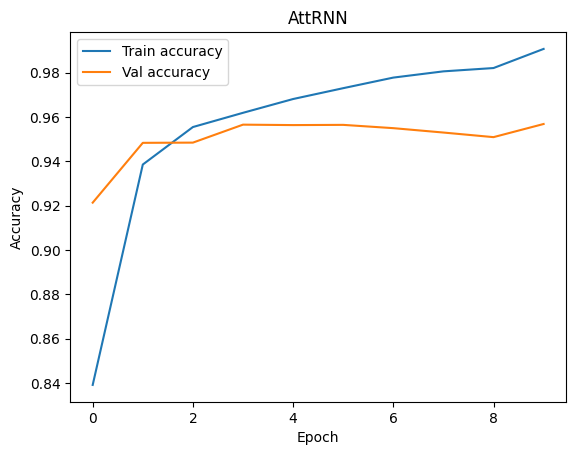

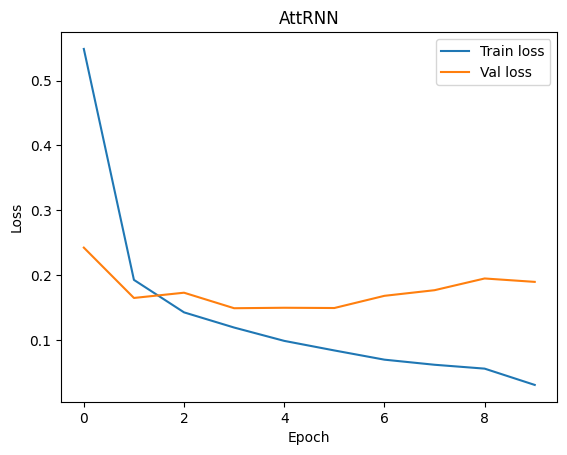

In [ ]:
plot_history(history_AttRNN, 'Accuracy')
plot_history(history_AttRNN, 'Loss')

## Residual Attention RNN

### Model architecture (general)

The idea is to replace the convolutional layers for convolutional blocks that may be more efficient at obtaining the features that will later go through the attention mechanism. In this case, the idea is to leverage the skip connections capacities and build a deeper network without ending up with a lot of parameters. I use dilation in order to get a greater receptive field with the same amount of parameters.

In [ ]:
@tf.keras.utils.register_keras_serializable()
class ConvResidualBlock(tf.keras.Model):
  def __init__(self, n_maps, kernel, n_layers):
    super(ConvResidualBlock, self).__init__()

    # First, a convolutional layer is added to match the later dimensions for skip connections)
    self.conv0 = layers.Conv2D(filters=n_maps, kernel_size=kernel, activation='relu',
                               use_bias=False, padding='same')

    # Then, apart from the previous layer, each block is composed
    # by n_layers-1 sequential sub-blocks made of BN, activation and convolution with dilation

    # Iterating over the sequential layers
    self.n_seq_layers = n_layers-1
    layers_list = []
    for i in range(self.n_seq_layers):
        # Computing an exponentially increasing dilation rate
        dilation_rate = 2 ** i

        # Bias-free convolutional layers with dilation (the order is due to the post-activation approach for the skip connections)
        layers_list.append(layers.BatchNormalization())
        layers_list.append(layers.Activation('relu'))
        layers_list.append(layers.Conv2D(n_maps, kernel, use_bias=False,
                                         padding='same', dilation_rate=(dilation_rate, 1)))

    # Adding the sequential block as an attribute
    self.sequential_sub_block = tf.keras.Sequential(layers_list)

    # Adding the skip connection as an attribute
    self.skip_connection = layers.Add()


  def call(self, X_input, training=False):

    # Calling the convolution to match the subsequent dimensions
    X_input = self.conv0(X_input)
    X = X_input

    # Calling the sub-blocks
    for i in range(self.n_seq_layers):
      X = self.sequential_sub_block(X_input, training=training)

    # Calling the skip connection
    X = self.skip_connection([X_input, X])
    return X

In [ ]:
def ResAttRNN(input_shape, settings):
    """
    Arguments:
    input_shape -- shape of the data of the dataset
    settings -- a dictionary with the configuration of the network

    Returns:
    model -- a tf.keras.Model() instance
    """

    # Extracting the parameters to build the architecture

    # Parameters for replacing the first convolutional layer of AttRNN
    n_conv_res_blocks1 = settings['n_conv_res_blocks1'] # Number of convolutional residual blocks
    n_layers1 = settings['n_layers1'] # Number of layers in each block
    n_maps1 = settings['n_maps1'] # Number of maps for the convolutional layers
    kernel1 = settings['kernel1'] # Filter size for the convolutional layers

    # Parameters for replacing the second convolutional layer of AttRNN
    n_conv_res_blocks2 = settings['n_conv_res_blocks2'] # Number of convolutional residual blocks
    n_layers2 = settings['n_layers2'] # Number of layers in each block
    n_maps2 = settings['n_maps2'] # Number of maps for the convolutional layers
    kernel2 = settings['kernel2'] # Filter size for the convolutional layers

    # Parameter for smoothing the attention scores before the softmax
    att_smoother = settings['att_smoother']

    # Number of units for the recurrent networks
    n_units_recurrent = settings['n_units_recurrent']


    #---------------------------------------------------------------------------
    # Network construction
    X_input = tf.keras.Input(input_shape)
    X = X_input

    # Replacing the first convolutional layer of the AttRNN with my ConvResidualBlock
    for i in range(n_conv_res_blocks1):
      X = ConvResidualBlock(n_maps=n_maps1, kernel=kernel1, n_layers=n_layers1)(X)

    # Replacing the second convolutional layer of the AttRNN with my ConvResidualBlock
    for i in range(n_conv_res_blocks2):
      X = ConvResidualBlock(n_maps=n_maps2, kernel=kernel2, n_layers=n_layers2)(X)

    # Squeezing the channels axis and passing the inputs sequentially to the bidirectional RNNs
    X = layers.Lambda(lambda q: tf.keras.backend.squeeze(q, -1), name='squeeze_last_dim')(X)

    X = layers.Bidirectional(layers.GRU(n_units_recurrent, return_sequences=True))(X)  # [b_s, seq_len, vec_dim]
    X = layers.Bidirectional(layers.GRU(n_units_recurrent, return_sequences=True))(X)  # [b_s, seq_len, vec_dim]

    X_last = layers.Lambda(lambda q: q[:, -1])(X)  # [b_s, vec_dim]

    # Getting the query vector for the attention mechanism
    query = layers.Dense(n_units_recurrent*2)(X_last)

    # Dot product attention
    attScores = layers.Dot(name='attScores', axes=[1, 2])([query, X])

    # Smoothing the attention scores as in the Chorowski paper
    if att_smoother:
      attScores = layers.Activation(att_smoother, name='attScores_bounded')(attScores)

    # Getting the attention weights
    attWeigths = layers.Softmax(name='attSoftmax')(attScores)  # [b_s, seq_len]

    # Weighted average of the RNNs outputs (context vector)
    attVector = layers.Dot(axes=[1, 1])([attWeigths, X])  # [b_s, vec_dim]

    # Dropout after the attention mechanism
    X = layers.Dropout(rate = 0.2)(X)

    # Dense layers
    X = layers.Dense(n_units_recurrent, activation='relu')(attVector)
    X = layers.Dense(n_units_recurrent/2)(X)

    # Dropout before the output layer
    X = layers.Dropout(rate = 0.2)(X)

    # Output layer
    output = layers.Dense(n_categories, activation='softmax', name='output')(X)

    model = tf.keras.Model(inputs=[X_input], outputs=[output], name='ResAttRNN')

    return model

### ResAttRNN1

#### Model compiling

A model with the new architecture (one 5-layer residual block for replacing each of the convolutional layers) and no attention smoother. The convolutions are performed along the time dimension only with a filter of size 3.

In [ ]:
# Defining the model's filename
filename_ResAttRNN1 = 'ResAttRNN1.keras'

In [ ]:
# Since all audios have the same length and I am computing
# 13 MFCC features, the input shape of each example will be (99, 13, 1)
# -the last axis is the channel dimension, which is added for consistency
# when convolving.
input_shape = (99, 13, 1) # (seq_len, features, channels)

# Defining the configuration of the model and creating it
settings_ResAttRNN1 = {'n_conv_res_blocks1': 1, 'n_layers1': 5, 'n_maps1': 5, 'kernel1':(3,1),
                       'n_conv_res_blocks2': 1, 'n_layers2': 5, 'n_maps2': 1, 'kernel2':(3,1),
                       'att_smoother':None, 'n_units_recurrent':64}
model_ResAttRNN1 = ResAttRNN(input_shape, settings_ResAttRNN1)


# Compiling the model with the adam optimizer and the categorical crossentropy loss and accuracy
model_ResAttRNN1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model_ResAttRNN1.summary()

Model: "ResAttRNN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 99, 13, 1)]          0         []                            
                                                                                                  
 conv_residual_block (ConvR  (None, 99, 13, 5)            395       ['input_2[0][0]']             
 esidualBlock)                                                                                    
                                                                                                  
 conv_residual_block_1 (Con  (None, 99, 13, 1)            43        ['conv_residual_block[0][0]'] 
 vResidualBlock)                                                                                  
                                                                                          

In [ ]:
# Saving the structure image of the model through building blocks
#save_model_structure(model_ResAttRNN1, filename_ResAttRNN1)

#### Model training

Training the model. As in the previous case, four callbacks are added: one for updating the learning rate of the optimizer, one for early stopping if the model is not improving its accuracy on the validation set, one for saving checkpoints at each epoch (and saves the best model in the end), and the one for timing the training process.

In [ ]:
"""num_epochs = 40

# Instantiating the callback to get the training time
time_callback_ResAttRNN1 = TimeCallback(filename_ResAttRNN1)

# Preparing the callback to save model's checkpoints to continue training in case of kernel death
# and to save the best model in the end.
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
# last_finished_epoch = 4  # replacing with the latest finished epoch
# model_ResAttRNN1 = load_model(path_models + filename_ResAttRNN1, safe_mode=False)

checkpoint_callback_ResAttRNN1 = tf.keras.callbacks.ModelCheckpoint(path_models + filename_ResAttRNN1,
                                                                    monitor='val_loss', save_best_only=True,
                                                                    verbose=1)

# Fitting the model
# the learning rate scheduler and the early stop callbacks are the same as in the AttRNN model
history_ResAttRNN1 = model_ResAttRNN1.fit(sc_train_processed, epochs=num_epochs,
                                          steps_per_epoch=train_steps,
                                          validation_data=sc_val_processed,
                                          validation_steps=val_steps,
                                          callbacks=[lr_scheduler_callback, early_stop_callback,
                                                     time_callback_ResAttRNN1, checkpoint_callback_ResAttRNN1],
                                          initial_epoch=last_finished_epoch or 0)
print('Training finished successfully.')"""

Changing learning rate to 0.001
Epoch 1/40
669/669 [==============================] - ETA: 0s - loss: 0.9415 - sparse_categorical_accuracy: 0.7394
Epoch 1: val_loss improved from inf to 0.30842, saving model to Models/ResAttRNN1.keras
669/669 [==============================] - 48s 41ms/step - loss: 0.9415 - sparse_categorical_accuracy: 0.7394 - val_loss: 0.3084 - val_sparse_categorical_accuracy: 0.9020 - lr: 0.0010
Changing learning rate to 0.001
Epoch 2/40
668/669 [============================>.] - ETA: 0s - loss: 0.2944 - sparse_categorical_accuracy: 0.9074
Epoch 2: val_loss improved from 0.30842 to 0.21936, saving model to Models/ResAttRNN1.keras
669/669 [==============================] - 24s 36ms/step - loss: 0.2943 - sparse_categorical_accuracy: 0.9075 - val_loss: 0.2194 - val_sparse_categorical_accuracy: 0.9300 - lr: 0.0010
Changing learning rate to 0.001
Epoch 3/40
669/669 [==============================] - ETA: 0s - loss: 0.2203 - sparse_categorical_accuracy: 0.9313
Epoch 3: va

In [ ]:
# Saving or loading the history object and the time callback object if necessary

# Saving
#save_object(obj=history_ResAttRNN1, file_label=filename_ResAttRNN1, type_obj='history')
#save_object(obj=time_callback_ResAttRNN1, file_label=filename_ResAttRNN1, type_obj='train_time')

# Loading
history_ResAttRNN1 = load_object(file_label=filename_ResAttRNN1, type_obj='history')
time_callback_ResAttRNN1 = load_object(file_label=filename_ResAttRNN1, type_obj='train_time')

Object saved as Others/ResAttRNN1_history.pkl
Object saved as Others/ResAttRNN1_train_time.pkl


Plotting the training and validation losses and accuracies.

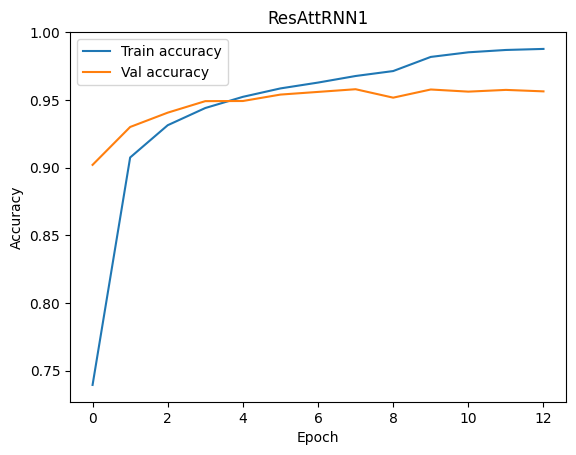

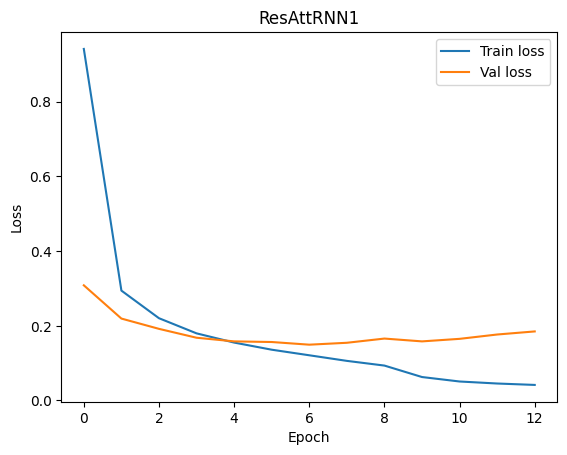

In [ ]:
plot_history(history_ResAttRNN1, 'Accuracy')
plot_history(history_ResAttRNN1, 'Loss')

### ResAttRNN2

#### Model compiling

A model with the new architecture (one 5-layer residual block for replacing each of the convolutional layers) and the **sigmoid** function as attention smoother. The convolutions are performed along the time dimension only with a filter of size 3.

In [ ]:
# Defining the model's filename
filename_ResAttRNN2 = 'ResAttRNN2.keras'

In [ ]:
# Since all audios have the same length and I am computing
# 13 MFCC features, the input shape of each example will be (99, 13, 1)
# -the last axis is the channel dimension, which is added for consistency
# when convolving.
input_shape = (99, 13, 1) # (seq_len, features, channels)

# Defining the configuration of the model and creating it
settings_ResAttRNN2 = {'n_conv_res_blocks1': 1, 'n_layers1': 5, 'n_maps1': 5, 'kernel1':(3,1),
                       'n_conv_res_blocks2': 1, 'n_layers2': 5, 'n_maps2': 1, 'kernel2':(3,1),
                       'att_smoother':'sigmoid', 'n_units_recurrent':64}
model_ResAttRNN2 = ResAttRNN(input_shape, settings_ResAttRNN2)


# Compiling the model with the adam optimizer and the categorical crossentropy loss and accuracy
model_ResAttRNN2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model_ResAttRNN2.summary()

Model: "ResAttRNN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 99, 13, 1)]          0         []                            
                                                                                                  
 conv_residual_block_2 (Con  (None, 99, 13, 5)            395       ['input_3[0][0]']             
 vResidualBlock)                                                                                  
                                                                                                  
 conv_residual_block_3 (Con  (None, 99, 13, 1)            43        ['conv_residual_block_2[0][0]'
 vResidualBlock)                                                    ]                             
                                                                                          

In [ ]:
# Saving the structure image of the model through building blocks
#save_model_structure(model_ResAttRNN2, filename_ResAttRNN2)

#### Model training

Training the model. All ResAttRNN models follow the same logic as the previous with respect to the callbacks.

In [ ]:
"""num_epochs = 40

# Instantiating the callback to get the training time
time_callback_ResAttRNN2 = TimeCallback(filename_ResAttRNN2)

# Preparing the callback to save model's checkpoints to continue training in case of kernel death
# and to save the best model in the end.
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
# last_finished_epoch = 4  # replacing with the latest finished epoch
# model_ResAttRNN2 = load_model(path_models + filename_ResAttRNN2, safe_mode=False)

checkpoint_callback_ResAttRNN2 = tf.keras.callbacks.ModelCheckpoint(path_models + filename_ResAttRNN2,
                                                      monitor='val_loss',
                                                      save_best_only=True,
                                                      verbose=1)

# Fitting the model
# the learning rate scheduler and the early stop callbacks are the same as in the AttRNN model
history_ResAttRNN2 = model_ResAttRNN2.fit(sc_train_processed, epochs=num_epochs,
                                          steps_per_epoch=train_steps,
                                          validation_data=sc_val_processed,
                                          validation_steps=val_steps,
                                          callbacks=[lr_scheduler_callback, early_stop_callback,
                                                     time_callback_ResAttRNN2, checkpoint_callback_ResAttRNN2],
                                          initial_epoch=last_finished_epoch or 0)
print('Training finished successfully.')"""

Changing learning rate to 0.001
Epoch 1/40
669/669 [==============================] - ETA: 0s - loss: 0.7578 - sparse_categorical_accuracy: 0.7868
Epoch 1: val_loss improved from inf to 0.28625, saving model to Models/ResAttRNN2.keras
669/669 [==============================] - 44s 42ms/step - loss: 0.7578 - sparse_categorical_accuracy: 0.7868 - val_loss: 0.2863 - val_sparse_categorical_accuracy: 0.9063 - lr: 0.0010
Changing learning rate to 0.001
Epoch 2/40
668/669 [============================>.] - ETA: 0s - loss: 0.2587 - sparse_categorical_accuracy: 0.9200
Epoch 2: val_loss improved from 0.28625 to 0.19561, saving model to Models/ResAttRNN2.keras
669/669 [==============================] - 25s 37ms/step - loss: 0.2587 - sparse_categorical_accuracy: 0.9200 - val_loss: 0.1956 - val_sparse_categorical_accuracy: 0.9377 - lr: 0.0010
Changing learning rate to 0.001
Epoch 3/40
669/669 [==============================] - ETA: 0s - loss: 0.1934 - sparse_categorical_accuracy: 0.9404
Epoch 3: va

In [ ]:
# Saving or loading the history object and the time callback object if necessary

# Saving
#save_object(obj=history_ResAttRNN2, file_label=filename_ResAttRNN2, type_obj='history')
#save_object(obj=time_callback_ResAttRNN2, file_label=filename_ResAttRNN2, type_obj='train_time')

# Loading
history_ResAttRNN2 = load_object(file_label=filename_ResAttRNN2, type_obj='history')
time_callback_ResAttRNN2 = load_object(file_label=filename_ResAttRNN2, type_obj='train_time')

Object saved as Others/ResAttRNN2_history.pkl
Object saved as Others/ResAttRNN2_train_time.pkl


Plotting the training and validation losses and accuracies.

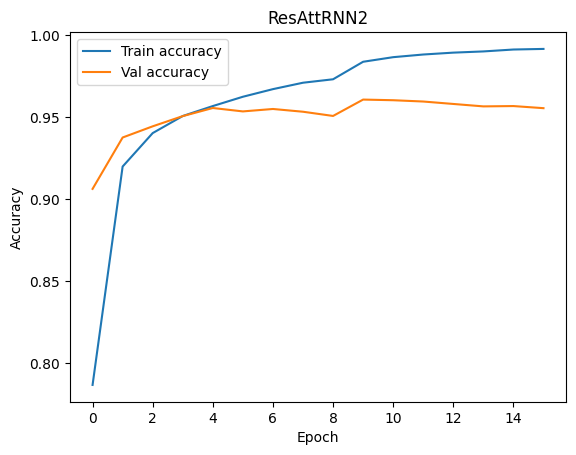

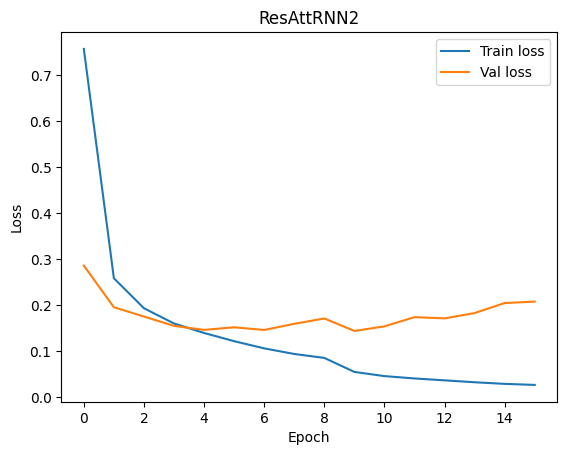

In [ ]:
plot_history(history_ResAttRNN2, 'Accuracy')
plot_history(history_ResAttRNN2, 'Loss')

### ResAttRNN3

#### Model compiling

A model with the new architecture (one 5-layer residual block with dilated convolutions for replacing each of the convolutional layers) and the **tanh** function as attention smoother. The convolutions are performed along the time dimension only with a filter of size 3.

In [ ]:
# Defining the model's filename
filename_ResAttRNN3 = 'ResAttRNN3.keras'

In [ ]:
# Since all audios have the same length and I am computing
# 13 MFCC features, the input shape of each example will be (99, 13, 1)
# -the last axis is the channel dimension, which is added for consistency
# when convolving.
input_shape = (99, 13, 1) # (seq_len, features, channels)

# Defining the configuration of the model and creating it
settings_ResAttRNN3 = {'n_conv_res_blocks1': 1, 'n_layers1': 5, 'n_maps1': 5, 'kernel1':(3,1),
                       'n_conv_res_blocks2': 1, 'n_layers2': 5, 'n_maps2': 1, 'kernel2':(3,1),
                       'att_smoother':'tanh', 'n_units_recurrent':64}
model_ResAttRNN3 = ResAttRNN(input_shape, settings_ResAttRNN3)


# Compiling the model with the adam optimizer and the categorical crossentropy loss and accuracy
model_ResAttRNN3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model_ResAttRNN3.summary()

Model: "ResAttRNN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 99, 13, 1)]          0         []                            
                                                                                                  
 conv_residual_block_4 (Con  (None, 99, 13, 5)            395       ['input_4[0][0]']             
 vResidualBlock)                                                                                  
                                                                                                  
 conv_residual_block_5 (Con  (None, 99, 13, 1)            43        ['conv_residual_block_4[0][0]'
 vResidualBlock)                                                    ]                             
                                                                                          

In [ ]:
# Saving the structure image of the model through building blocks
#save_model_structure(model_ResAttRNN3, filename_ResAttRNN3)

#### Model training

Training the model. All ResAttRNN models follow the same logic as the previous with respect to the callbacks.

In [ ]:
"""num_epochs = 40

# Instantiating the callback to get the training time
time_callback_ResAttRNN3 = TimeCallback(filename_ResAttRNN3)

# Preparing the callback to save model's checkpoints to continue training in case of kernel death
# and to save the best model in the end.
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
# last_finished_epoch = 4  # replacing with the latest finished epoch
# model_ResAttRNN3 = load_model(path_models + filename_ResAttRNN3, safe_mode=False)

checkpoint_callback_ResAttRNN3 = tf.keras.callbacks.ModelCheckpoint(path_models + filename_ResAttRNN3,
                                                                    monitor='val_loss',
                                                                    save_best_only=True,
                                                                    verbose=1)

# Fitting the model
# the learning rate scheduler and the early stop callbacks are the same as in the AttRNN model
history_ResAttRNN3 = model_ResAttRNN3.fit(sc_train_processed, epochs=num_epochs,
                                          steps_per_epoch=train_steps,
                                          validation_data=sc_val_processed,
                                          validation_steps=val_steps,
                                          callbacks=[lr_scheduler_callback, early_stop_callback,
                                                     time_callback_ResAttRNN3, checkpoint_callback_ResAttRNN3],
                                          initial_epoch=last_finished_epoch or 0)
print('Training finished successfully.')"""

Changing learning rate to 0.001
Epoch 1/40
669/669 [==============================] - ETA: 0s - loss: 1.0369 - sparse_categorical_accuracy: 0.7121
Epoch 1: val_loss improved from inf to 0.37684, saving model to Models/ResAttRNN3.keras
669/669 [==============================] - 44s 42ms/step - loss: 1.0369 - sparse_categorical_accuracy: 0.7121 - val_loss: 0.3768 - val_sparse_categorical_accuracy: 0.8842 - lr: 0.0010
Changing learning rate to 0.001
Epoch 2/40
668/669 [============================>.] - ETA: 0s - loss: 0.3177 - sparse_categorical_accuracy: 0.9009
Epoch 2: val_loss improved from 0.37684 to 0.21110, saving model to Models/ResAttRNN3.keras
669/669 [==============================] - 24s 37ms/step - loss: 0.3175 - sparse_categorical_accuracy: 0.9010 - val_loss: 0.2111 - val_sparse_categorical_accuracy: 0.9339 - lr: 0.0010
Changing learning rate to 0.001
Epoch 3/40
668/669 [============================>.] - ETA: 0s - loss: 0.2133 - sparse_categorical_accuracy: 0.9346
Epoch 3: va

In [ ]:
# Saving or loading the history object and the time callback object if necessary

# Saving
#save_object(obj=history_ResAttRNN3, file_label=filename_ResAttRNN3, type_obj='history')
#save_object(obj=time_callback_ResAttRNN3, file_label=filename_ResAttRNN3, type_obj='train_time')

# Loading
history_ResAttRNN3 = load_object(file_label=filename_ResAttRNN3, type_obj='history')
time_callback_ResAttRNN3 = load_object(file_label=filename_ResAttRNN3, type_obj='train_time')

Object saved as Others/ResAttRNN3_history.pkl
Object saved as Others/ResAttRNN3_train_time.pkl


Plotting the training and validation losses and accuracies.

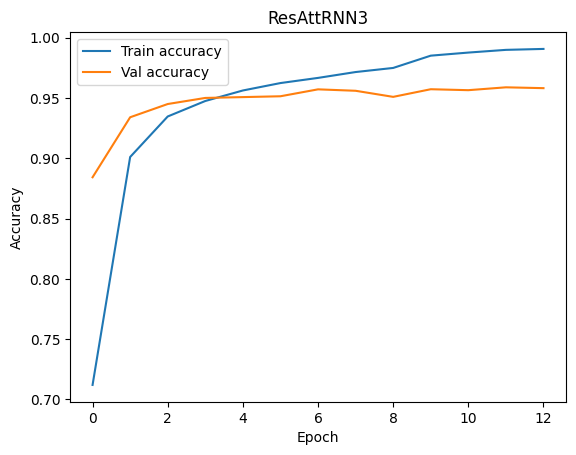

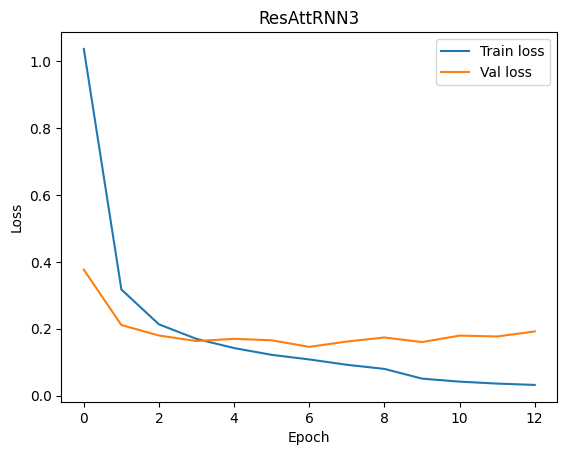

In [ ]:
plot_history(history_ResAttRNN3, 'Accuracy')
plot_history(history_ResAttRNN3, 'Loss')

### ResAttRNN4

#### Model compiling

A heavier model. It follows the residual architecture more closely (it is much deeper and the blocks are similar to the ones in the paper in terms of parameters). The convolutions are still made along the time dimension only. No recurrent units are removed.

In [ ]:
# Defining the model's filename
filename_ResAttRNN4 = 'ResAttRNN4.keras'

In [ ]:
# Since all audios have the same length and I am computing
# 13 MFCC features, the input shape of each example will be (99, 13, 1)
# -the last axis is the channel dimension, which is added for consistency
# when convolving.
input_shape = (99, 13, 1) # (seq_len, features, channels)

# Defining the configuration of the model and creating it
settings_ResAttRNN4 = {'n_conv_res_blocks1': 6, 'n_layers1': 3, 'n_maps1': 45, 'kernel1':(3,1),
                       'n_conv_res_blocks2': 1, 'n_layers2': 3, 'n_maps2': 1, 'kernel2':(3,1),
                       'att_smoother':'tanh', 'n_units_recurrent':64}
model_ResAttRNN4 = ResAttRNN(input_shape, settings_ResAttRNN4)


# Compiling the model with the adam optimizer and the categorical crossentropy loss and accuracy
model_ResAttRNN4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model_ResAttRNN4.summary()

Model: "ResAttRNN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 99, 13, 1)]          0         []                            
                                                                                                  
 conv_residual_block_6 (Con  (None, 99, 13, 45)           12645     ['input_5[0][0]']             
 vResidualBlock)                                                                                  
                                                                                                  
 conv_residual_block_7 (Con  (None, 99, 13, 45)           18585     ['conv_residual_block_6[0][0]'
 vResidualBlock)                                                    ]                             
                                                                                          

In [ ]:
# Saving the structure image of the model through building blocks
#save_model_structure(model_ResAttRNN4, filename_ResAttRNN4)

#### Model training

Training the model. All ResAttRNN models follow the same logic as the previous with respect to the callbacks.

In [ ]:
"""num_epochs = 40

# Instantiating the callback to get the training time
time_callback_ResAttRNN4 = TimeCallback(filename_ResAttRNN4)

# Preparing the callback to save model's checkpoints to continue training in case of kernel death
# and to save the best model in the end.
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
# last_finished_epoch = 4  # replacing with the latest finished epoch
# model_ResAttRNN4 = load_model(path_models + filename_ResAttRNN4, safe_mode=False)

checkpoint_callback_ResAttRNN4 = tf.keras.callbacks.ModelCheckpoint(path_models + filename_ResAttRNN4,
                                                                    monitor='val_loss', save_best_only=True,
                                                                    verbose=1)

# Fitting the model
# the learning rate scheduler and the early stop callbacks are the same as in the AttRNN model
history_ResAttRNN4 = model_ResAttRNN4.fit(sc_train_processed, epochs=num_epochs,
                                          steps_per_epoch=train_steps,
                                          validation_data=sc_val_processed,
                                          validation_steps=val_steps,
                                          callbacks=[lr_scheduler_callback, early_stop_callback,
                                                     time_callback_ResAttRNN4, checkpoint_callback_ResAttRNN4],
                                          initial_epoch=last_finished_epoch or 0)
print('Training finished successfully.')"""

Changing learning rate to 0.001
Epoch 1/40
669/669 [==============================] - ETA: 0s - loss: 0.6051 - sparse_categorical_accuracy: 0.8238
Epoch 1: val_loss improved from inf to 0.31713, saving model to Models/ResAttRNN4.keras
669/669 [==============================] - 137s 175ms/step - loss: 0.6051 - sparse_categorical_accuracy: 0.8238 - val_loss: 0.3171 - val_sparse_categorical_accuracy: 0.9046 - lr: 0.0010
Changing learning rate to 0.001
Epoch 2/40
669/669 [==============================] - ETA: 0s - loss: 0.2338 - sparse_categorical_accuracy: 0.9279
Epoch 2: val_loss improved from 0.31713 to 0.21413, saving model to Models/ResAttRNN4.keras
669/669 [==============================] - 113s 169ms/step - loss: 0.2338 - sparse_categorical_accuracy: 0.9279 - val_loss: 0.2141 - val_sparse_categorical_accuracy: 0.9344 - lr: 0.0010
Changing learning rate to 0.001
Epoch 3/40
669/669 [==============================] - ETA: 0s - loss: 0.1849 - sparse_categorical_accuracy: 0.9428
Epoch 3

In [ ]:
# Saving or loading the history object and the time callback object if necessary

# Saving
#save_object(obj=history_ResAttRNN4, file_label=filename_ResAttRNN4, type_obj='history')
#save_object(obj=time_callback_ResAttRNN4, file_label=filename_ResAttRNN4, type_obj='train_time')

# Loading
history_ResAttRNN4 = load_object(file_label=filename_ResAttRNN4, type_obj='history')
time_callback_ResAttRNN4 = load_object(file_label=filename_ResAttRNN4, type_obj='train_time')

Object saved as Others/ResAttRNN4_history.pkl
Object saved as Others/ResAttRNN4_train_time.pkl


Plotting the training and validation losses and accuracies.

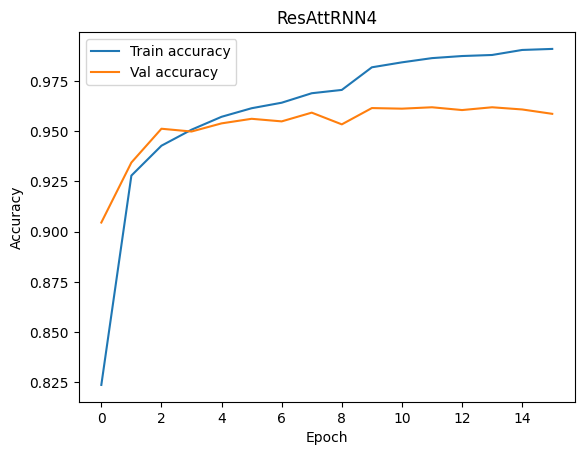

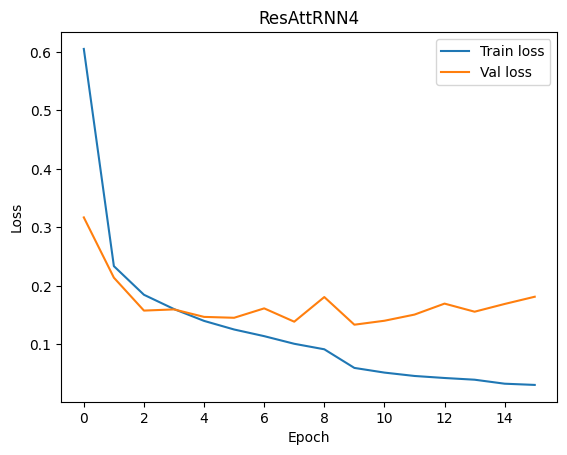

In [ ]:
plot_history(history_ResAttRNN4, 'Accuracy')
plot_history(history_ResAttRNN4, 'Loss')

### ResAttRNN5

#### Model compiling

An attempt to reduce the recurrent units by improving the feature representation that the recurrent layers receive as input. In this case, the convolution is two-dimensional (also along the MFCC dimension).

In [ ]:
# Defining the model's filename
filename_ResAttRNN5 = 'ResAttRNN5.keras'

In [ ]:
# Since all audios have the same length and I am computing
# 13 MFCC features, the input shape of each example will be (99, 13, 1)
# -the last axis is the channel dimension, which is added for consistency
# when convolving.
input_shape = (99, 13, 1) # (seq_len, features, channels)

# Defining the configuration of the model and creating it
settings_ResAttRNN5 = {'n_conv_res_blocks1': 5, 'n_layers1': 3, 'n_maps1': 25, 'kernel1':(3,3),
                       'n_conv_res_blocks2': 1, 'n_layers2': 3, 'n_maps2': 1, 'kernel2':(3,3),
                       'att_smoother':'tanh', 'n_units_recurrent':48}
model_ResAttRNN5 = ResAttRNN(input_shape, settings_ResAttRNN5)


# Compiling the model with the adam optimizer and the categorical crossentropy loss and accuracy
model_ResAttRNN5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model_ResAttRNN5.summary()

Model: "ResAttRNN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 99, 13, 1)]          0         []                            
                                                                                                  
 conv_residual_block_13 (Co  (None, 99, 13, 25)           11675     ['input_6[0][0]']             
 nvResidualBlock)                                                                                 
                                                                                                  
 conv_residual_block_14 (Co  (None, 99, 13, 25)           17075     ['conv_residual_block_13[0][0]
 nvResidualBlock)                                                   ']                            
                                                                                          

In [ ]:
# Saving the structure image of the model through building blocks
#save_model_structure(model_ResAttRNN5, filename_ResAttRNN5)

#### Model training

Training the model. All ResAttRNN models follow the same logic as the previous with respect to the callbacks.

In [ ]:
"""num_epochs = 40

# Instantiating the callback to get the training time
time_callback_ResAttRNN5 = TimeCallback(filename_ResAttRNN5)

# Preparing the callback to save model's checkpoints to continue training in case of kernel death
# and to save the best model in the end.
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#last_finished_epoch = 7  # replacing with the latest finished epoch
#model_ResAttRNN5 = load_model(path_models + filename_ResAttRNN5, safe_mode=False)

checkpoint_callback_ResAttRNN5 = tf.keras.callbacks.ModelCheckpoint(path_models + filename_ResAttRNN5,
                                                                    monitor='val_loss', save_best_only=True,
                                                                    verbose=1)

# Fitting the model
# the learning rate scheduler and the early stop callbacks are the same as in the AttRNN model
history_ResAttRNN5 = model_ResAttRNN5.fit(sc_train_processed, epochs=num_epochs,
                                          steps_per_epoch=train_steps,
                                          validation_data=sc_val_processed,
                                          validation_steps=val_steps,
                                          callbacks=[lr_scheduler_callback, early_stop_callback,
                                                     time_callback_ResAttRNN5, checkpoint_callback_ResAttRNN5],
                                          initial_epoch=last_finished_epoch or 0)
print('Training finished successfully.')"""

Changing learning rate to 0.001
Epoch 1/40
669/669 [==============================] - ETA: 0s - loss: 0.7156 - sparse_categorical_accuracy: 0.7928
Epoch 1: val_loss improved from inf to 0.31467, saving model to Models/ResAttRNN5.keras
669/669 [==============================] - 86s 102ms/step - loss: 0.7156 - sparse_categorical_accuracy: 0.7928 - val_loss: 0.3147 - val_sparse_categorical_accuracy: 0.9029 - lr: 0.0010
Changing learning rate to 0.001
Epoch 2/40
669/669 [==============================] - ETA: 0s - loss: 0.2910 - sparse_categorical_accuracy: 0.9115
Epoch 2: val_loss improved from 0.31467 to 0.22820, saving model to Models/ResAttRNN5.keras
669/669 [==============================] - 65s 98ms/step - loss: 0.2910 - sparse_categorical_accuracy: 0.9115 - val_loss: 0.2282 - val_sparse_categorical_accuracy: 0.9290 - lr: 0.0010
Changing learning rate to 0.001
Epoch 3/40
669/669 [==============================] - ETA: 0s - loss: 0.2209 - sparse_categorical_accuracy: 0.9330
Epoch 3: v

In [ ]:
# Saving or loading the history object and the time callback object if necessary

# Saving
#save_object(obj=history_ResAttRNN5, file_label=filename_ResAttRNN5, type_obj='history')
#save_object(obj=time_callback_ResAttRNN5, file_label=filename_ResAttRNN5, type_obj='train_time')

# Loading
history_ResAttRNN5 = load_object(file_label=filename_ResAttRNN5, type_obj='history')
time_callback_ResAttRNN5 = load_object(file_label=filename_ResAttRNN5, type_obj='train_time')

Object saved as Others/ResAttRNN5_history.pkl
Object saved as Others/ResAttRNN5_train_time.pkl


Plotting the training and validation losses and accuracies.

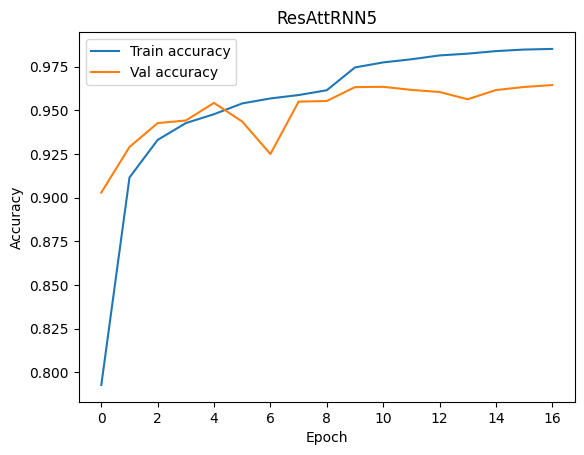

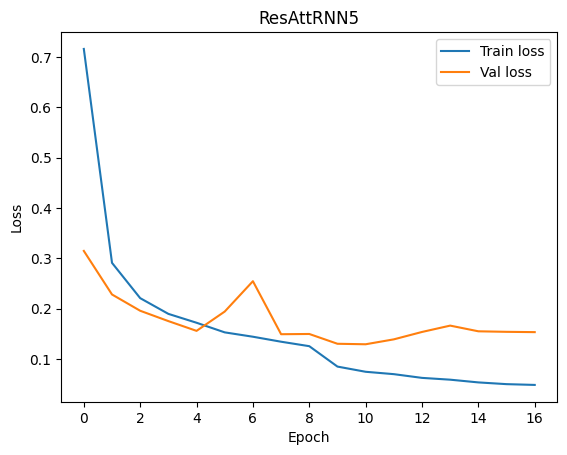

In [ ]:
plot_history(history_ResAttRNN5, 'Accuracy')
plot_history(history_ResAttRNN5, 'Loss')

## Transformer-based encoder and classifier

Just to have a comparison with a very different approach, I implemented a transformer-based encoder and classifier.

It takes the MFCC features as input and passes through an encoder that is based on the one from the original transformer. Then, the contextualized result is passed through a dense interpolation layer and through the final classification layer.

### Model architecture (general)

The architecture is organized in blocks and then it is assembled together.

#### The encoder

##### Building blocks: positional encoding

First, the positional encoding is added to the input of the encoder. I use the same encoding as in the original paper.

In [ ]:
def positional_encoding(length, depth):
    """
    The code below implements positional encoding.
    NB: Instead of interleaving the sines and cosines, the vectors of sines and
    cosines are simply concatenated.
    Permuting the channels in this way is functionally equivalent,
    and a bit easier to implement.

    Code adjusted to account also for an odd number as depth.
    """

    if depth % 2 == 0:
      depth_sin = depth//2
      depth_cos = depth_sin
    else:
      depth_sin = depth//2 + 1
      depth_cos = depth//2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)

    depths_sin = 2 * np.arange(depth_sin)[np.newaxis, :]/depth   # (1, depth_sin)
    angle_rates_sin = 1 / (10000**depths_sin)         # (1, depth_sin)
    angle_rads_sin = positions * angle_rates_sin      # (pos, depth_sin)

    depths_cos = 2 * np.arange(depth_cos)[np.newaxis, :]/depth   # (1, depth_cos)
    angle_rates_cos = 1 / (10000**depths_cos)         # (1, depth_cos)
    angle_rads_cos = positions * angle_rates_cos      # (pos, depth_cos)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads_sin), np.cos(angle_rads_cos)],
        axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
@tf.keras.utils.register_keras_serializable()
class PositionalEncodingLayer(tf.keras.layers.Layer):
  def __init__(self, seq_length, x_dim):
    super().__init__()
    self.x_dim = x_dim
    self.pos_encoding = positional_encoding(length=seq_length, depth=x_dim)

  def call(self, x):
    length = tf.shape(x)[1]
    x *= tf.math.sqrt(tf.cast(self.x_dim, tf.float32))
    pos_enc = self.pos_encoding[tf.newaxis, :length, :]
    x = x + pos_enc
    return x

##### Building blocks: attention layer

In [ ]:
@tf.keras.utils.register_keras_serializable()
class GlobalSelfAttention(layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = layers.MultiHeadAttention(**kwargs)
    self.add = layers.Add()
    self.layernorm = layers.LayerNormalization()

  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

##### Building blocks: the feed forward network

In [ ]:
@tf.keras.utils.register_keras_serializable()
class FeedForward(layers.Layer):
  def __init__(self, x_dim, ff_dim, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        layers.Dense(ff_dim, activation='relu'),
        layers.Dense(x_dim),
        layers.Dropout(dropout_rate)])
    self.add = layers.Add()
    self.layer_norm = layers.LayerNormalization()

  def call(self, x):
    # forward the input through the seq model
    x_seq = self.seq(x)
    # used the add layer to combine x and x_seq
    x = self.add([x, x_seq])
    # forward the output through layer_norm
    x = self.layer_norm(x)
    return x

##### Putting the building blocks together

In [ ]:
@tf.keras.utils.register_keras_serializable()
class EncoderLayer(layers.Layer):
  def __init__(self, *, x_dim, num_heads, ff_dim, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=x_dim,
        dropout=dropout_rate)

    self.ffn = FeedForward(x_dim, ff_dim)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [ ]:
@tf.keras.utils.register_keras_serializable()
class Encoder(layers.Layer):
  def __init__(self, *, seq_length, x_dim,
               num_layers,  num_heads, ff_dim,
               dropout_rate=0.1):
    super().__init__()

    self.x_dim = x_dim
    self.num_layers = num_layers

    self.pos_encoding = PositionalEncodingLayer(
        seq_length=seq_length, x_dim=x_dim)

    self.enc_layers = [
        EncoderLayer(x_dim=x_dim,
                     num_heads=num_heads,
                     ff_dim=ff_dim,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = layers.Dropout(dropout_rate)

  def call(self, x):
    # Positional encoding
    x = self.pos_encoding(x)  # Shape (batch_size, seq_len, x_dim).

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape (batch_size, seq_len, x_dim).

#### Dense interpolation

The dense interpolation layer is defined as it was done in the *Attend and Diagnose* paper.

In [ ]:
@tf.keras.utils.register_keras_serializable()
class DenseInterpolation(tf.keras.layers.Layer):
    def __init__(self, seq_len, factor):
        super(DenseInterpolation, self).__init__()

        W = np.zeros((factor, seq_len), dtype=np.float32)

        for t in range(seq_len):
            s = np.array((factor * (t + 1)) / seq_len, dtype=np.float32)
            for m in range(factor):
                tmp = np.array(1 - (np.abs(s - (1+m)) / factor), dtype=np.float32)
                w = np.power(tmp, 2, dtype=np.float32)
                W[m, t] = w

        W = tf.convert_to_tensor(W, dtype=tf.float32)
        self.W = tf.Variable(initial_value=W, trainable=False)

    def call(self, X):
        w = tf.expand_dims(self.W, axis=0)
        w = tf.tile(w, [tf.shape(X)[0], 1, 1])
        u = tf.matmul(w, X)
        return u

#### The final classifier

Now, I can define the final classifier by stacking the encoder, the dense interpolation and one final dense layer for the classification.

In [ ]:
@tf.keras.utils.register_keras_serializable()
class TransfEncoderClassifier(tf.keras.Model):
  def __init__(self, *, seq_length, x_dim,
               num_layers, num_heads, ff_dim,
               dense_interpolation_factor,
               dropout_rate=0.1):
    super().__init__()

    self.encoder = Encoder(seq_length=seq_length, x_dim=x_dim,
                           num_layers=num_layers,  num_heads=num_heads, ff_dim=ff_dim,
                           dropout_rate=dropout_rate)

    self.dense_interpolator = DenseInterpolation(seq_len=seq_length,
                                                 factor=dense_interpolation_factor)
    self.flatten = layers.Flatten()

    self.output_layer = layers.Dense(n_categories, activation='softmax', name='output')

  def call(self, X_input, training=False):

    # Executing the pass in order
    X = self.encoder(X_input)  # (batch_size, seq_len, x_dim)

    X = self.dense_interpolator(X)  # (batch_size, factor, x_dim)

    X = self.flatten(X)  # (batch_size, factor * x_dim)

    X = self.output_layer(X)  # (batch_size, n_categories)

    # Return the final softmax scores.
    return X

### General settings and optimizer

General settings to both transformer-based models, which will be used later but are defined here for clarity. The input shape, x_dim (the MFCCs features), will be used for the optimizer right below.

In [ ]:
# In this case, the batch dimension is passed explicitly by adding None at the beginning
# Because for these models it is necessary to call the build() method, and
# this method expects that kind of format
input_shape_transf = (None, 99, 13) # (batch_size, seq_len, features)

seq_length = input_shape_transf[1]
x_dim = input_shape_transf[2]

dropout_rate = 0.1 # User defined

In [ ]:
@tf.keras.utils.register_keras_serializable()
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, x_dim, warmup_steps=4000):
    super().__init__()

    self.x_dim = x_dim
    self.x_dim = tf.cast(self.x_dim, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.x_dim) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    return {"x_dim": float(self.x_dim), "warmup_steps": self.warmup_steps}

Instantiation of the customized Adam optimizer.

In [ ]:
learning_rate_transformer = CustomSchedule(x_dim)

optimizer_transformer1 = tf.keras.optimizers.Adam(learning_rate_transformer, beta_1=0.9, beta_2=0.98,
                                                  epsilon=1e-9)

Visualize how the learning rate varies with the training steps by using the custom learning rate scheduler.

Text(0.5, 0, 'Train Step')

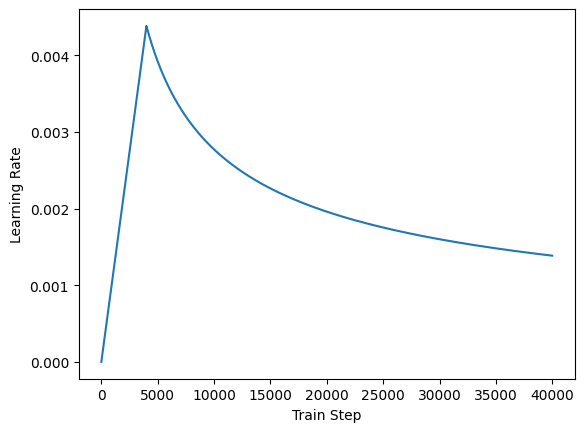

In [ ]:
plt.plot(learning_rate_transformer(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### TransfClassifier1

#### Model compiling

This is a lighter model than the AttRNN in terms of memory.

In [ ]:
# Defining the model's filename
filename_TransfClassifier1 = 'TransfClassifier1.keras'

In [ ]:
# Defining the model hyperparameters
num_layers_transf1 = 4 # User defined
num_heads_transf1 = 8  # User defined
ff_dim_transf1 = 896  # User defined

dense_interpolation_factor_transf1 = 60 # User defined

In [ ]:
model_TransfClassifier1 = TransfEncoderClassifier(seq_length=seq_length, x_dim=x_dim,
                                                  num_layers=num_layers_transf1,  num_heads=num_heads_transf1, ff_dim=ff_dim_transf1,
                                                  dense_interpolation_factor=dense_interpolation_factor_transf1,
                                                  dropout_rate=dropout_rate)

# Because of the way the model was defined, it was necessary to call the build() method.
# Otherwise it results in an error.
model_TransfClassifier1.build(input_shape=input_shape_transf)
model_TransfClassifier1.compile(optimizer=optimizer_transformer1, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model_TransfClassifier1.summary()

Model: "transf_encoder_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  119960    
                                                                 
 dense_interpolation (Dense  multiple                  5940      
 Interpolation)                                                  
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 output (Dense)              multiple                  9372      
                                                                 
Total params: 135272 (528.41 KB)
Trainable params: 129332 (505.20 KB)
Non-trainable params: 5940 (23.20 KB)
_________________________________________________________________


In [ ]:
# Saving the structure image of the model through building blocks
#save_model_structure(model_TransfClassifier1, filename_TransfClassifier1)

#### Model training

Training the model. Similarly to what was done for the RNN models, three callbacks are added: one for early stopping if the model is not improving its accuracy on the validation set, one for saving checkpoints at each epoch (and saves the best model in the end), and the one for timing the training process.

The early stopping callback was already defined for the RNN models so it is reused.

The callback for updating the learning rate of the optimizer is not necessary since this was done above, with a LearningSchedule within the optimizer.

In [ ]:
"""num_epochs = 40

# Instantiating the callback to get the training time
time_callback_TransfClassifier1 = TimeCallback(filename_TransfClassifier1)

# Preparing the callback to save model's checkpoints to continue training in case of kernel death
# and to save the best model in the end.
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#last_finished_epoch = 1  # replacing with the latest finished epoch
#model_TransfClassifier1 = load_model(path_models + filename_TransfClassifier1, safe_mode=False)

checkpoint_callback_TransfClassifier1 = tf.keras.callbacks.ModelCheckpoint(path_models + filename_TransfClassifier1,
                                                                           monitor='val_loss', save_best_only=True,
                                                                           verbose=1)

# Fitting the model
# the learning rate scheduler and the early stop callbacks are the same as in the AttRNN model
history_TransfClassifier1 = model_TransfClassifier1.fit(sc_train_processed_transf,
                                                        epochs=num_epochs,
                                                        steps_per_epoch=train_steps,
                                                        validation_data=sc_val_processed_transf,
                                                        validation_steps=val_steps,
                                                        callbacks=[early_stop_callback,
                                                                   time_callback_TransfClassifier1, checkpoint_callback_TransfClassifier1],
                                                        initial_epoch=last_finished_epoch or 0)
print('Training finished successfully.')"""

Epoch 1/40
669/669 [==============================] - ETA: 0s - loss: 5.6565 - sparse_categorical_accuracy: 0.5276
Epoch 1: val_loss improved from inf to 1.19545, saving model to Models/TransfClassifier1.keras
669/669 [==============================] - 86s 85ms/step - loss: 5.6565 - sparse_categorical_accuracy: 0.5276 - val_loss: 1.1955 - val_sparse_categorical_accuracy: 0.6812
Epoch 2/40
669/669 [==============================] - ETA: 0s - loss: 1.2422 - sparse_categorical_accuracy: 0.6852
Epoch 2: val_loss did not improve from 1.19545
669/669 [==============================] - 49s 73ms/step - loss: 1.2422 - sparse_categorical_accuracy: 0.6852 - val_loss: 1.2753 - val_sparse_categorical_accuracy: 0.6267
Epoch 3/40
669/669 [==============================] - ETA: 0s - loss: 0.8748 - sparse_categorical_accuracy: 0.7448
Epoch 3: val_loss improved from 1.19545 to 0.73237, saving model to Models/TransfClassifier1.keras
669/669 [==============================] - 48s 72ms/step - loss: 0.8748 

In [ ]:
# Saving or loading the history object and the time callback object if necessary

# Saving
#save_object(obj=history_TransfClassifier1, file_label=filename_TransfClassifier1, type_obj='history')
#save_object(obj=time_callback_TransfClassifier1, file_label=filename_TransfClassifier1, type_obj='train_time')

# Loading
history_TransfClassifier1 = load_object(file_label=filename_TransfClassifier1, type_obj='history')
time_callback_TransfClassifier1 = load_object(file_label=filename_TransfClassifier1, type_obj='train_time')

Object saved as Others/TransfClassifier1_history.pkl
Object saved as Others/TransfClassifier1_train_time.pkl


Plotting the training and validation losses and accuracies.

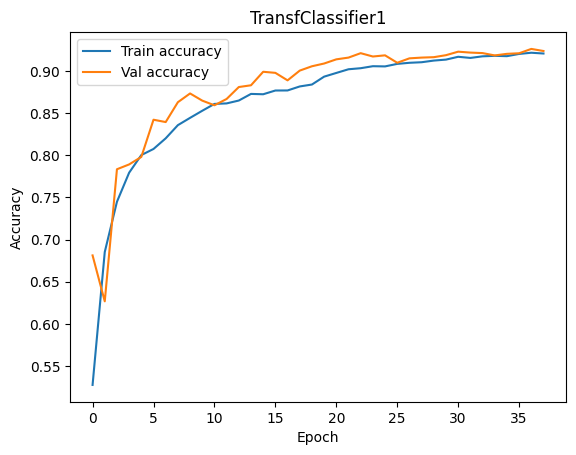

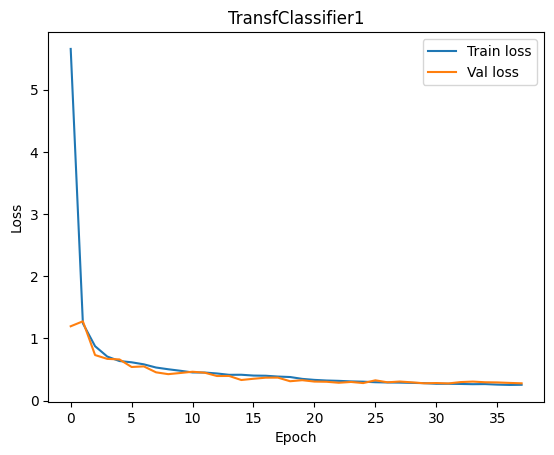

In [ ]:
plot_history(history_TransfClassifier1, 'Accuracy')
plot_history(history_TransfClassifier1, 'Loss')

### TransfClassifier2

#### Model compiling

In this case, I fix the amount of interpolated units (the factor) and tweak the other hyperparameters to end up with a heavier version of the model.

In [ ]:
# Defining the model's filename
filename_TransfClassifier2 = 'TransfClassifier2.keras'

In [ ]:
# Defining the model hyperparameters
num_layers_transf2 = 6 # User defined
num_heads_transf2 = 10  # User defined
ff_dim_transf2 = 1024  # User defined

dense_interpolation_factor_transf2 = 60 # User defined

Instantiate the customized Adam optimizer (because of the way it is coded, I need an optimizer for each model).

In [ ]:
optimizer_transformer2 = tf.keras.optimizers.Adam(learning_rate_transformer, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [ ]:
model_TransfClassifier2 = TransfEncoderClassifier(seq_length=seq_length, x_dim=x_dim,
                                                  num_layers=num_layers_transf2,  num_heads=num_heads_transf2, ff_dim=ff_dim_transf2,
                                                  dense_interpolation_factor=dense_interpolation_factor_transf2,
                                                  dropout_rate=dropout_rate)

# Because of the way the model was defined, it was necessary to call the build() method.
# Otherwise it results in an error.
model_TransfClassifier2.build(input_shape=input_shape_transf)
model_TransfClassifier2.compile(optimizer=optimizer_transformer2, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model_TransfClassifier2.summary()

Model: "transf_encoder_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  209256    
                                                                 
 dense_interpolation_1 (Den  multiple                  5940      
 seInterpolation)                                                
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 output (Dense)              multiple                  9372      
                                                                 
Total params: 224568 (877.22 KB)
Trainable params: 218628 (854.02 KB)
Non-trainable params: 5940 (23.20 KB)
_________________________________________________________________


In [ ]:
# Saving the structure image of the model through building blocks
#save_model_structure(model_TransfClassifier2, filename_TransfClassifier2)

#### Model training

Training the model. All transformer-based models follow the same logic.

In [ ]:
"""num_epochs = 40

# Instantiating the callback to get the training time
time_callback_TransfClassifier2 = TimeCallback(filename_TransfClassifier2)

# Preparing the callback to save model's checkpoints to continue training in case of kernel death
# and to save the best model in the end.
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
# last_finished_epoch = 4  # replacing with the latest finished epoch
# model_TransfClassifier2 = load_model(path_models + filename_TransfClassifier2, safe_mode=False)

checkpoint_callback_TransfClassifier2 = tf.keras.callbacks.ModelCheckpoint(path_models + filename_TransfClassifier2,
                                                                           monitor='val_loss', save_best_only=True,
                                                                           verbose=1)

# Fitting the model
# the learning rate scheduler and the early stop callbacks are the same as in the AttRNN model
history_TransfClassifier2 = model_TransfClassifier2.fit(sc_train_processed_transf,
                                                        epochs=num_epochs,
                                                        steps_per_epoch=train_steps,
                                                        validation_data=sc_val_processed_transf,
                                                        validation_steps=val_steps,
                                                        callbacks=[early_stop_callback,
                                                                   time_callback_TransfClassifier2, checkpoint_callback_TransfClassifier2],
                                                        initial_epoch=last_finished_epoch or 0)
print('Training finished successfully.')"""

Epoch 1/40
669/669 [==============================] - ETA: 0s - loss: 4.8440 - sparse_categorical_accuracy: 0.5246
Epoch 1: val_loss improved from inf to 1.57355, saving model to Models/TransfClassifier2.keras
669/669 [==============================] - 102s 126ms/step - loss: 4.8440 - sparse_categorical_accuracy: 0.5246 - val_loss: 1.5735 - val_sparse_categorical_accuracy: 0.6571
Epoch 2/40
669/669 [==============================] - ETA: 0s - loss: 1.5780 - sparse_categorical_accuracy: 0.6750
Epoch 2: val_loss improved from 1.57355 to 1.49593, saving model to Models/TransfClassifier2.keras
669/669 [==============================] - 82s 122ms/step - loss: 1.5780 - sparse_categorical_accuracy: 0.6750 - val_loss: 1.4959 - val_sparse_categorical_accuracy: 0.7249
Epoch 3/40
669/669 [==============================] - ETA: 0s - loss: 1.2583 - sparse_categorical_accuracy: 0.7244
Epoch 3: val_loss improved from 1.49593 to 1.01751, saving model to Models/TransfClassifier2.keras
669/669 [========

In [ ]:
# Saving or loading the history object and the time callback object if necessary

# Saving
#save_object(obj=history_TransfClassifier2, file_label=filename_TransfClassifier2, type_obj='history')
#save_object(obj=time_callback_TransfClassifier2, file_label=filename_TransfClassifier2, type_obj='train_time')

# Loading
history_TransfClassifier2 = load_object(file_label=filename_TransfClassifier2, type_obj='history')
time_callback_TransfClassifier2 = load_object(file_label=filename_TransfClassifier2, type_obj='train_time')

Object saved as Others/TransfClassifier2_history.pkl
Object saved as Others/TransfClassifier2_train_time.pkl


Plotting the training and validation losses and accuracies.

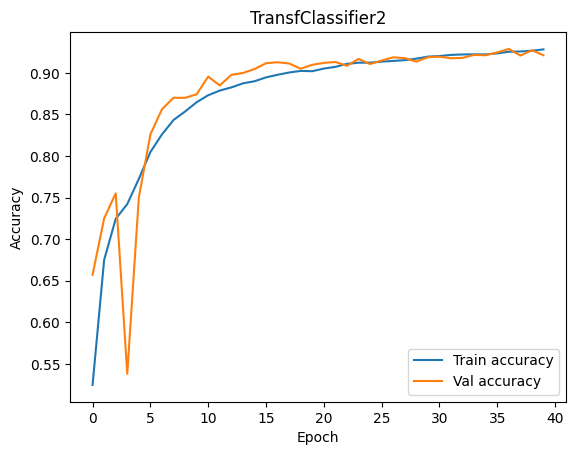

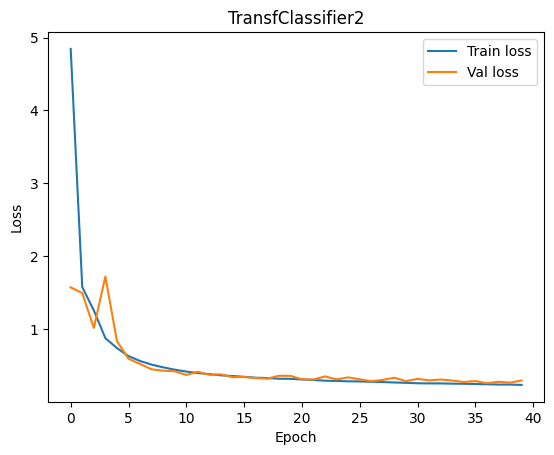

In [ ]:
plot_history(history_TransfClassifier2, 'Accuracy')
plot_history(history_TransfClassifier2, 'Loss')

### TransfClassifier3

#### Model compiling

In contrast to the previous model, now I fix the amount of interpolated units (the factor) and tweak the other hyperparameters to end up with a lighter version of the model.

In [ ]:
# Defining the model's filename
filename_TransfClassifier3 = 'TransfClassifier3.keras'

In [ ]:
# Defining the model parameters
num_layers_transf3 = 4 # User defined
num_heads_transf3 = 8  # User defined
ff_dim_transf3 = 768  # User defined

dense_interpolation_factor_transf3 = 60 # User defined

Instantiate the customized Adam optimizer.

In [ ]:
optimizer_transformer3 = tf.keras.optimizers.Adam(learning_rate_transformer, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [ ]:
model_TransfClassifier3 = TransfEncoderClassifier(seq_length=seq_length, x_dim=x_dim,
                                                  num_layers=num_layers_transf3,  num_heads=num_heads_transf3, ff_dim=ff_dim_transf3,
                                                  dense_interpolation_factor=dense_interpolation_factor_transf3,
                                                  dropout_rate=dropout_rate)

# Because of the way the model was defined, it was necessary to call the build() method.
# Otherwise it results in an error.
model_TransfClassifier3.build(input_shape=input_shape_transf)
model_TransfClassifier3.compile(optimizer=optimizer_transformer3, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model_TransfClassifier3.summary()

Model: "transf_encoder_classifier_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_2 (Encoder)         multiple                  106136    
                                                                 
 dense_interpolation_2 (Den  multiple                  5940      
 seInterpolation)                                                
                                                                 
 flatten_2 (Flatten)         multiple                  0         
                                                                 
 output (Dense)              multiple                  9372      
                                                                 
Total params: 121448 (474.41 KB)
Trainable params: 115508 (451.20 KB)
Non-trainable params: 5940 (23.20 KB)
_________________________________________________________________


In [ ]:
# Saving the structure image of the model through building blocks
#save_model_structure(model_TransfClassifier3, filename_TransfClassifier3)

#### Model training

Training the model. Similarly to what was done for the RNN models, three callbacks are added: one for early stopping if the model is not improving its accuracy on the validation set, one for saving checkpoints at each epoch (and saves the best model in the end), and the one for timing the training process.

The early stopping callback was already defined for the RNN models so it is reused and the callback for updating the learning rate of the optimizer is not necessary as this was done above, with a LearningSchedule within the optimizer.

In [ ]:
"""num_epochs = 40

# Instantiating the callback to get the training time
time_callback_TransfClassifier3 = TimeCallback(filename_TransfClassifier3)

# Preparing the callback to save model's checkpoints to continue training in case of kernel death
# and to save the best model in the end.
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
# last_finished_epoch = 4  # replacing with the latest finished epoch
# model_TransfClassifier3 = load_model(path_models + filename_TransfClassifier3, safe_mode=False)

checkpoint_callback_TransfClassifier3 = tf.keras.callbacks.ModelCheckpoint(path_models + filename_TransfClassifier3,
                                                                           monitor='val_loss', save_best_only=True,
                                                                           verbose=1)

# Fitting the model
# the learning rate scheduler and the early stop callbacks are the same as in the AttRNN model
history_TransfClassifier3 = model_TransfClassifier3.fit(sc_train_processed_transf,
                                                        epochs=num_epochs,
                                                        steps_per_epoch=train_steps,
                                                        validation_data=sc_val_processed_transf,
                                                        validation_steps=val_steps,
                                                        callbacks=[early_stop_callback,
                                                                   time_callback_TransfClassifier3, checkpoint_callback_TransfClassifier3],
                                                        initial_epoch=last_finished_epoch or 0)
print('Training finished successfully.')"""

Epoch 1/40
669/669 [==============================] - ETA: 0s - loss: 4.9022 - sparse_categorical_accuracy: 0.5469
Epoch 1: val_loss improved from inf to 1.17348, saving model to Models/TransfClassifier3.keras
669/669 [==============================] - 60s 71ms/step - loss: 4.9022 - sparse_categorical_accuracy: 0.5469 - val_loss: 1.1735 - val_sparse_categorical_accuracy: 0.6833
Epoch 2/40
669/669 [==============================] - ETA: 0s - loss: 1.1435 - sparse_categorical_accuracy: 0.6964
Epoch 2: val_loss improved from 1.17348 to 0.92656, saving model to Models/TransfClassifier3.keras
669/669 [==============================] - 47s 70ms/step - loss: 1.1435 - sparse_categorical_accuracy: 0.6964 - val_loss: 0.9266 - val_sparse_categorical_accuracy: 0.7275
Epoch 3/40
669/669 [==============================] - ETA: 0s - loss: 0.8680 - sparse_categorical_accuracy: 0.7455
Epoch 3: val_loss improved from 0.92656 to 0.90537, saving model to Models/TransfClassifier3.keras
669/669 [===========

In [ ]:
# Saving or loading the history object and the time callback object if necessary

# Saving
#save_object(obj=history_TransfClassifier3, file_label=filename_TransfClassifier3, type_obj='history')
#save_object(obj=time_callback_TransfClassifier3, file_label=filename_TransfClassifier3, type_obj='train_time')

# Loading
history_TransfClassifier3 = load_object(file_label=filename_TransfClassifier3, type_obj='history')
time_callback_TransfClassifier3 = load_object(file_label=filename_TransfClassifier3, type_obj='train_time')

Object saved as Others/TransfClassifier3_history.pkl
Object saved as Others/TransfClassifier3_train_time.pkl


Plotting the training and validation losses and accuracies.

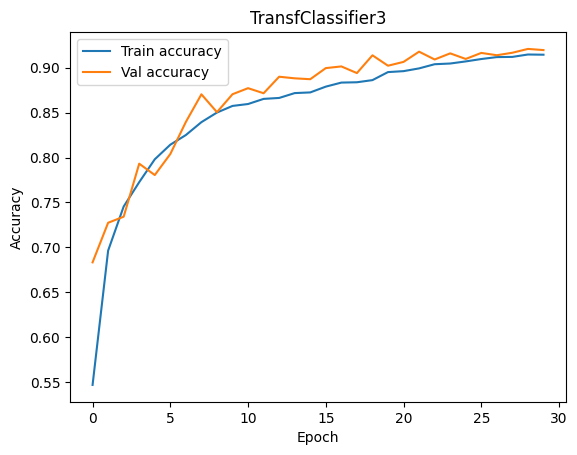

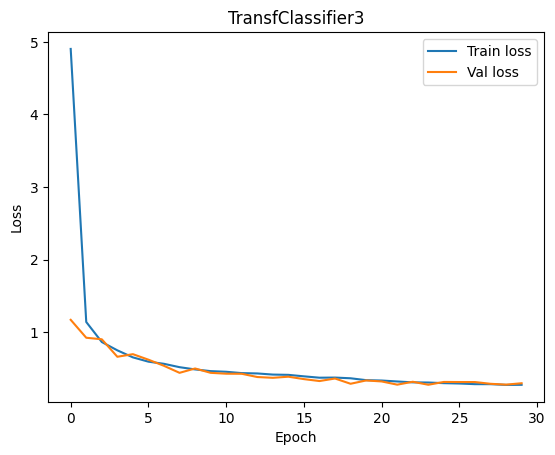

In [ ]:
plot_history(history_TransfClassifier3, 'Accuracy')
plot_history(history_TransfClassifier3, 'Loss')

## Performance assessment

Loading the models if necessary. First, it is needed to run the cells that define the architecture since I have some custom classes.

In [ ]:
filename_AttRNN = 'AttRNN.keras'
model_AttRNN = load_model(path_models + filename_AttRNN, safe_mode=False)
time_callback_AttRNN = load_object(file_label=filename_AttRNN, type_obj='train_time')

filename_ResAttRNN1 = 'ResAttRNN1.keras'
model_ResAttRNN1 = load_model(path_models + filename_ResAttRNN1, safe_mode=False)
time_callback_ResAttRNN1 = load_object(file_label=filename_ResAttRNN1, type_obj='train_time')

filename_ResAttRNN2 = 'ResAttRNN2.keras'
model_ResAttRNN2 = load_model(path_models + filename_ResAttRNN2, safe_mode=False)
time_callback_ResAttRNN2 = load_object(file_label=filename_ResAttRNN2, type_obj='train_time')

filename_ResAttRNN3 = 'ResAttRNN3.keras'
model_ResAttRNN3 = load_model(path_models + filename_ResAttRNN3, safe_mode=False)
time_callback_ResAttRNN3 = load_object(file_label=filename_ResAttRNN3, type_obj='train_time')

filename_ResAttRNN4 = 'ResAttRNN4.keras'
model_ResAttRNN4 = load_model(path_models + filename_ResAttRNN4, safe_mode=False)
time_callback_ResAttRNN4 = load_object(file_label=filename_ResAttRNN4, type_obj='train_time')

filename_ResAttRNN5 = 'ResAttRNN5.keras'
model_ResAttRNN5 = load_model(path_models + filename_ResAttRNN5, safe_mode=False)
time_callback_ResAttRNN5 = load_object(file_label=filename_ResAttRNN5, type_obj='train_time')


#-------------------------------------------------------------------------------

filename_TransfClassifier1 = 'TransfClassifier1.keras'
model_TransfClassifier1 = load_model(path_models + filename_TransfClassifier1, safe_mode=False)
time_callback_TransfClassifier1 = load_object(file_label=filename_TransfClassifier1, type_obj='train_time')

filename_TransfClassifier2 = 'TransfClassifier2.keras'
model_TransfClassifier2 = load_model(path_models + filename_TransfClassifier2, safe_mode=False)
time_callback_TransfClassifier2 = load_object(file_label=filename_TransfClassifier2, type_obj='train_time')

filename_TransfClassifier3 = 'TransfClassifier3.keras'
model_TransfClassifier3 = load_model(path_models + filename_TransfClassifier3, safe_mode=False)
time_callback_TransfClassifier3 = load_object(file_label=filename_TransfClassifier3, type_obj='train_time')

Object loaded from Others/AttRNN_train_time.pkl
Object loaded from Others/ResAttRNN1_train_time.pkl
Object loaded from Others/ResAttRNN2_train_time.pkl
Object loaded from Others/ResAttRNN3_train_time.pkl
Object loaded from Others/ResAttRNN4_train_time.pkl
Object loaded from Others/ResAttRNN5_train_time.pkl
Object loaded from Others/TransfClassifier1_train_time.pkl
Object loaded from Others/TransfClassifier2_train_time.pkl
Object loaded from Others/TransfClassifier3_train_time.pkl


Getting the ground truth for making the comparisons.

In [ ]:
# Getting the ground truth for making the comparisons
y_true_test = tf.concat(list(sc_test_processed.take(test_steps).map(lambda data,label: label)), axis=0)[:test_length]
y_true_test = y_true_test.numpy()
y_true_test

array([ 7,  2,  6, ..., 10,  9,  5])

Function to obtain the results for each model on the test set. It measures loss, accuracy, precision, recall, Fscore, training time and prediction time. It also plots the confusion matrix.

In [ ]:
def model_results(model, time_callback, model_label, model_type='RNN', save=False):

  # Since both type of models have slightly different preprocessing pipelines,
  # the testing dataset should be adjusted accordingly
  if model_type == 'RNN':
    dataset = sc_test_processed
  elif model_type == 'transf_encoder_classifier':
    dataset = sc_test_processed_transf

  # Getting the predictions (probabilities and then classes)
  y_pred_test = model.predict(dataset, steps=test_steps,
                              callbacks=[time_callback])[:test_length]
  y_pred_class_test = y_pred_test.argmax(axis=1)

  # Getting the accuracy, precision, recall and fscore
  accuracy = accuracy_score(y_true_test, y_pred_class_test)

  precision, recall, fscore, _ = precision_recall_fscore_support(y_true_test, y_pred_class_test, average='weighted')

  # Getting the training and predicting (testing) times
  training_time = time_callback.training_time
  prediction_time = time_callback.prediction_time

  # Getting the confusion matrix
  confusion_mat = confusion_matrix(y_true_test, y_pred_class_test)

  # Displaying the confusion matrix
  disp = ConfusionMatrixDisplay(confusion_mat, display_labels=label_names)
  fig, ax = plt.subplots()
  disp.plot(ax=ax, colorbar=False)
  plt.xticks(rotation=45)

  # Organizing everything in a dictionary
  model_name = model_label.split('.')[0]
  results = {'Model': model_name,
             'Accuracy':accuracy,
             'Precision':precision,'Recall':recall, 'F-score':fscore,
             'Training time (s)':training_time, 'Prediction time (s)':prediction_time,
             'Confusion matrix': confusion_mat.tolist()}


  if save:
    filename_results = path_others + model_name + '_results.json'
    with open(filename_results, 'w') as f:
      json.dump(results, f, indent=4)
    print(f'Results object saved as {filename_results}')

    # Saving the confusion matrix plot if required
    plt.title(model_name)
    filename_plot = path_plots + model_name + '_CM.pdf'
    plt.tight_layout()
    plt.savefig(filename_plot)

  return results, y_pred_class_test

### Results AttRNN

39/39 [==============================] - 5s 13ms/step
Results object saved as Others/AttRNN_results.json


{'Model': 'AttRNN',
 'Accuracy': 0.9259713701431492,
 'Precision': 0.9400162137506626,
 'Recall': 0.9259713701431492,
 'F-score': 0.9292843756888229,
 'Training time (s)': 197.84339785575867,
 'Prediction time (s)': 5.202239751815796,
 'Confusion matrix': [[376, 3, 0, 4, 0, 1, 0, 0, 0, 0, 1, 21],
  [7, 361, 0, 7, 1, 0, 0, 2, 1, 0, 1, 22],
  [0, 0, 380, 0, 1, 0, 2, 0, 0, 0, 1, 28],
  [11, 7, 0, 359, 0, 0, 0, 0, 1, 0, 0, 27],
  [0, 1, 2, 0, 348, 2, 0, 2, 30, 0, 0, 17],
  [8, 0, 0, 0, 7, 344, 0, 0, 2, 0, 2, 33],
  [1, 0, 1, 0, 0, 0, 374, 0, 0, 0, 1, 19],
  [1, 1, 0, 1, 0, 0, 0, 401, 1, 0, 0, 6],
  [2, 0, 2, 0, 1, 4, 0, 3, 381, 0, 2, 30],
  [0, 0, 5, 0, 0, 0, 0, 0, 0, 404, 0, 10],
  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 401, 6],
  [1, 2, 0, 5, 0, 0, 0, 0, 0, 0, 1, 399]]}

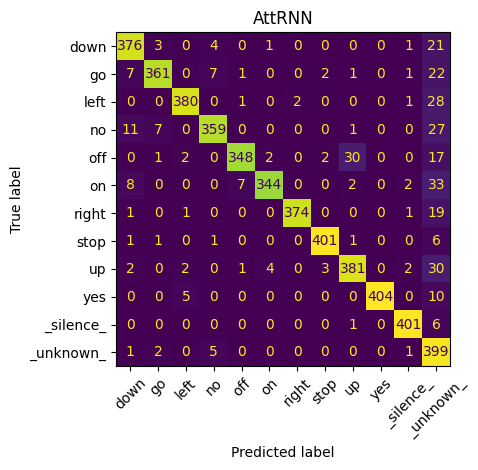

In [ ]:
results_AttRNN, y_pred_class_AttRNN = model_results(model=model_AttRNN, time_callback=time_callback_AttRNN,
                                                    model_label=filename_AttRNN, save=False)
results_AttRNN

### Results ResAttRNN1

39/39 [==============================] - 4s 11ms/step
Results object saved as Others/ResAttRNN1_results.json


{'Model': 'ResAttRNN1',
 'Accuracy': 0.9141104294478528,
 'Precision': 0.9323951665862006,
 'Recall': 0.9141104294478528,
 'F-score': 0.9185379054801568,
 'Training time (s)': 347.5316836833954,
 'Prediction time (s)': 3.8045578002929688,
 'Confusion matrix': [[337, 15, 0, 10, 0, 0, 0, 1, 0, 1, 1, 41],
  [0, 368, 0, 5, 0, 1, 0, 0, 1, 0, 1, 26],
  [0, 0, 379, 0, 2, 0, 1, 0, 0, 8, 1, 21],
  [3, 14, 1, 344, 0, 0, 0, 0, 1, 0, 0, 42],
  [0, 4, 1, 0, 355, 3, 0, 0, 23, 0, 0, 16],
  [0, 3, 0, 0, 13, 355, 0, 0, 2, 0, 0, 23],
  [0, 0, 3, 0, 2, 0, 363, 0, 0, 0, 0, 28],
  [1, 0, 0, 0, 0, 0, 0, 403, 2, 0, 0, 5],
  [1, 1, 0, 0, 5, 1, 0, 3, 392, 0, 2, 20],
  [0, 0, 7, 0, 1, 0, 0, 0, 0, 403, 1, 7],
  [0, 1, 0, 0, 1, 0, 0, 0, 3, 0, 376, 27],
  [1, 3, 0, 2, 2, 1, 2, 0, 0, 0, 2, 395]]}

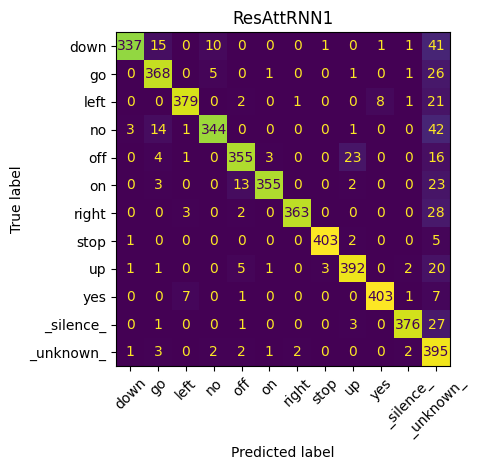

In [ ]:
results_ResAttRNN1, y_pred_class_ResAttRNN1 = model_results(model=model_ResAttRNN1, time_callback=time_callback_ResAttRNN1,
                                                            model_label=filename_ResAttRNN1, save=False)
results_ResAttRNN1

### Results ResAttRNN2

39/39 [==============================] - 5s 19ms/step
Results object saved as Others/ResAttRNN2_results.json


{'Model': 'ResAttRNN2',
 'Accuracy': 0.9202453987730062,
 'Precision': 0.9379767816493887,
 'Recall': 0.9202453987730062,
 'F-score': 0.9246616678194466,
 'Training time (s)': 412.17650961875916,
 'Prediction time (s)': 5.289887428283691,
 'Confusion matrix': [[350, 4, 0, 17, 0, 0, 0, 0, 0, 0, 1, 34],
  [3, 354, 0, 12, 0, 0, 0, 0, 2, 0, 1, 30],
  [0, 0, 377, 0, 2, 0, 0, 0, 0, 13, 1, 19],
  [1, 6, 0, 378, 0, 0, 0, 0, 0, 1, 0, 19],
  [0, 3, 0, 3, 347, 4, 0, 0, 15, 1, 0, 29],
  [4, 0, 0, 0, 5, 361, 0, 0, 3, 0, 1, 22],
  [0, 0, 1, 0, 0, 0, 375, 0, 0, 0, 1, 19],
  [0, 1, 0, 0, 0, 0, 0, 395, 2, 0, 0, 13],
  [0, 2, 0, 1, 7, 4, 0, 2, 374, 0, 1, 34],
  [0, 0, 1, 0, 0, 0, 0, 0, 0, 408, 1, 9],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 385, 23],
  [0, 1, 0, 4, 0, 3, 1, 1, 1, 0, 1, 396]]}

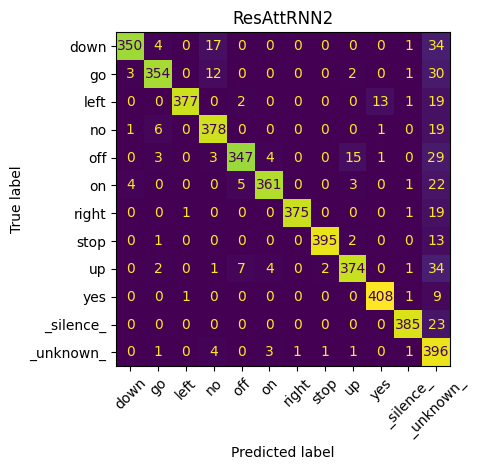

In [ ]:
results_ResAttRNN2, y_pred_class_ResAttRNN2 = model_results(model=model_ResAttRNN2, time_callback=time_callback_ResAttRNN2,
                                                            model_label=filename_ResAttRNN2, save=False)
results_ResAttRNN2

### Results ResAttRNN3

39/39 [==============================] - 3s 13ms/step
Results object saved as Others/ResAttRNN3_results.json


{'Model': 'ResAttRNN3',
 'Accuracy': 0.9159509202453988,
 'Precision': 0.937066176019942,
 'Recall': 0.9159509202453988,
 'F-score': 0.9210814331723962,
 'Training time (s)': 337.08879590034485,
 'Prediction time (s)': 3.4363653659820557,
 'Confusion matrix': [[354, 3, 0, 12, 0, 0, 0, 1, 0, 1, 1, 34],
  [10, 344, 0, 9, 1, 0, 0, 0, 1, 0, 1, 36],
  [0, 0, 391, 1, 0, 0, 0, 0, 0, 4, 1, 15],
  [3, 7, 0, 359, 0, 0, 0, 0, 3, 1, 0, 32],
  [0, 5, 3, 0, 351, 3, 0, 1, 13, 0, 0, 26],
  [3, 1, 0, 0, 5, 340, 0, 0, 6, 0, 1, 40],
  [0, 0, 5, 0, 0, 0, 353, 0, 1, 0, 1, 36],
  [1, 0, 0, 1, 0, 0, 0, 393, 2, 0, 1, 13],
  [0, 2, 0, 0, 4, 4, 0, 0, 387, 0, 2, 26],
  [0, 0, 2, 0, 0, 0, 0, 0, 0, 407, 1, 9],
  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 396, 11],
  [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 404]]}

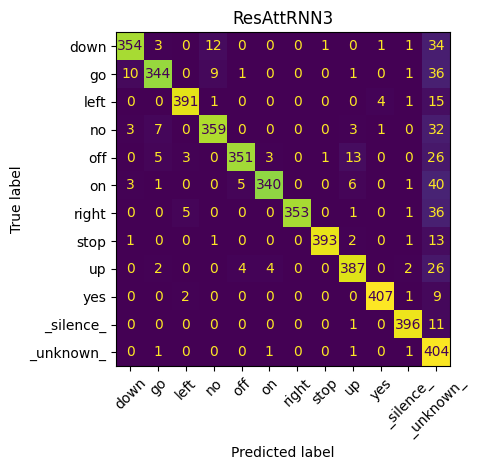

In [ ]:
results_ResAttRNN3, y_pred_class_ResAttRNN3 = model_results(model=model_ResAttRNN3, time_callback=time_callback_ResAttRNN3,
                                                            model_label=filename_ResAttRNN3, save=False)
results_ResAttRNN3

### Results ResAttRNN4

39/39 [==============================] - 5s 40ms/step
Results object saved as Others/ResAttRNN4_results.json


{'Model': 'ResAttRNN4',
 'Accuracy': 0.9392638036809816,
 'Precision': 0.949432706321572,
 'Recall': 0.9392638036809816,
 'F-score': 0.9415987502812198,
 'Training time (s)': 1812.5787460803986,
 'Prediction time (s)': 4.6638031005859375,
 'Confusion matrix': [[359, 2, 0, 16, 0, 1, 0, 0, 1, 1, 1, 25],
  [4, 354, 0, 6, 1, 0, 0, 0, 0, 0, 1, 36],
  [0, 0, 392, 0, 2, 0, 0, 0, 0, 4, 0, 14],
  [2, 6, 0, 378, 0, 0, 0, 0, 1, 0, 0, 18],
  [0, 1, 0, 1, 369, 2, 0, 0, 15, 0, 0, 14],
  [4, 0, 0, 0, 9, 365, 0, 0, 2, 0, 2, 14],
  [0, 0, 2, 0, 1, 0, 368, 0, 0, 0, 1, 24],
  [0, 0, 0, 0, 0, 0, 0, 407, 0, 0, 0, 4],
  [1, 4, 0, 0, 7, 1, 0, 3, 394, 0, 1, 14],
  [0, 0, 0, 0, 1, 0, 0, 0, 0, 411, 0, 7],
  [0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 394, 10],
  [1, 0, 0, 3, 0, 0, 0, 1, 0, 0, 1, 402]]}

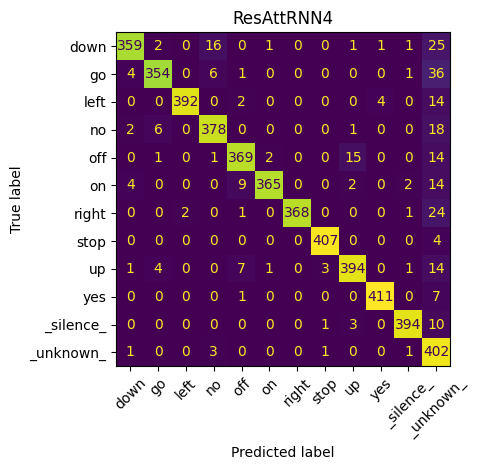

In [ ]:
results_ResAttRNN4, y_pred_class_ResAttRNN4 = model_results(model=model_ResAttRNN4, time_callback=time_callback_ResAttRNN4,
                                                            model_label=filename_ResAttRNN4, save=False)
results_ResAttRNN4

### Results ResAttRNN5

39/39 [==============================] - 5s 26ms/step
Results object saved as Others/ResAttRNN5_results.json


{'Model': 'ResAttRNN5',
 'Accuracy': 0.932719836400818,
 'Precision': 0.9458580224935291,
 'Recall': 0.932719836400818,
 'F-score': 0.93595151400113,
 'Training time (s)': 1134.018793106079,
 'Prediction time (s)': 5.265721559524536,
 'Confusion matrix': [[370, 1, 1, 10, 0, 1, 0, 0, 0, 0, 1, 22],
  [15, 355, 0, 12, 0, 0, 0, 0, 0, 0, 1, 19],
  [0, 0, 393, 1, 0, 0, 0, 0, 0, 0, 1, 17],
  [0, 2, 0, 380, 0, 0, 0, 0, 2, 1, 0, 20],
  [0, 3, 0, 0, 366, 6, 0, 0, 16, 0, 0, 11],
  [0, 1, 0, 0, 4, 354, 0, 0, 8, 0, 0, 29],
  [1, 0, 3, 0, 0, 0, 371, 0, 0, 0, 1, 20],
  [1, 0, 0, 0, 0, 0, 0, 398, 5, 0, 1, 6],
  [0, 0, 0, 0, 7, 5, 0, 0, 391, 0, 1, 21],
  [0, 0, 3, 0, 0, 0, 0, 0, 0, 402, 0, 14],
  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 379, 28],
  [0, 1, 0, 4, 0, 0, 0, 0, 0, 0, 1, 402]]}

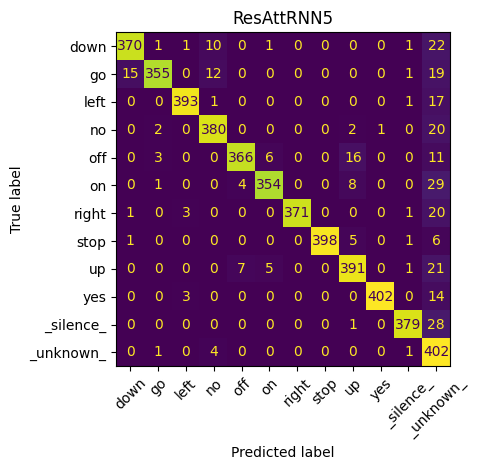

In [ ]:
results_ResAttRNN5, y_pred_class_ResAttRNN5 = model_results(model=model_ResAttRNN5, time_callback=time_callback_ResAttRNN5,
                                                            model_label=filename_ResAttRNN5, save=False)
results_ResAttRNN5

### Results TransfClassifier1

39/39 [==============================] - 4s 33ms/step
Results object saved as Others/TransfClassifier1_results.json


{'Model': 'TransfClassifier1',
 'Accuracy': 0.847239263803681,
 'Precision': 0.9010684414151637,
 'Recall': 0.847239263803681,
 'F-score': 0.8614724352872953,
 'Training time (s)': 1886.2208597660065,
 'Prediction time (s)': 4.242964506149292,
 'Confusion matrix': [[350, 3, 1, 12, 0, 0, 0, 0, 0, 0, 1, 39],
  [18, 304, 0, 19, 0, 1, 0, 0, 2, 0, 0, 58],
  [1, 0, 348, 1, 2, 0, 1, 0, 0, 15, 0, 44],
  [10, 8, 3, 326, 0, 2, 0, 0, 3, 0, 0, 53],
  [1, 1, 1, 1, 345, 13, 0, 0, 8, 0, 0, 32],
  [2, 0, 0, 0, 3, 339, 0, 1, 3, 0, 0, 48],
  [0, 0, 5, 0, 0, 0, 318, 1, 0, 0, 0, 72],
  [0, 1, 1, 1, 0, 0, 0, 379, 5, 0, 0, 24],
  [0, 2, 5, 0, 27, 6, 0, 8, 330, 0, 1, 46],
  [0, 0, 2, 0, 1, 0, 1, 0, 0, 387, 0, 28],
  [0, 0, 1, 0, 0, 0, 1, 9, 1, 0, 321, 75],
  [1, 2, 3, 3, 0, 2, 0, 1, 0, 0, 0, 396]]}

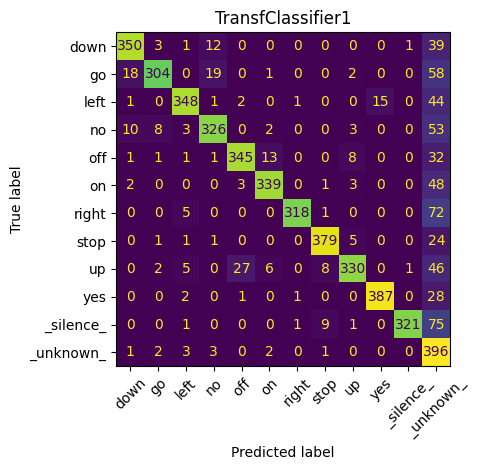

In [ ]:
results_TransfClassifier1, y_pred_class_TransfClassifier1 = model_results(model=model_TransfClassifier1, time_callback=time_callback_TransfClassifier1,
                                                                          model_label=filename_TransfClassifier1, model_type='transf_encoder_classifier',
                                                                          save=False)
results_TransfClassifier1

### Results TransfClassifier2

39/39 [==============================] - 3s 48ms/step
Results object saved as Others/TransfClassifier2_results.json


{'Model': 'TransfClassifier2',
 'Accuracy': 0.874437627811861,
 'Precision': 0.9069017585383099,
 'Recall': 0.874437627811861,
 'F-score': 0.8826647125610287,
 'Training time (s)': 3279.9437732696533,
 'Prediction time (s)': 2.989595413208008,
 'Confusion matrix': [[357, 4, 0, 11, 0, 0, 0, 0, 0, 1, 1, 32],
  [12, 327, 0, 15, 2, 1, 0, 0, 3, 0, 1, 41],
  [1, 0, 357, 1, 1, 0, 5, 1, 2, 16, 1, 27],
  [16, 10, 2, 333, 0, 3, 0, 1, 2, 0, 0, 38],
  [0, 1, 0, 1, 347, 11, 0, 2, 13, 0, 0, 27],
  [4, 0, 1, 0, 3, 331, 0, 1, 1, 0, 1, 54],
  [2, 0, 1, 0, 0, 0, 334, 1, 0, 2, 1, 55],
  [1, 1, 0, 0, 0, 0, 0, 378, 5, 0, 0, 26],
  [1, 2, 2, 0, 27, 8, 0, 9, 339, 0, 2, 35],
  [0, 0, 1, 0, 1, 0, 0, 0, 0, 406, 0, 11],
  [0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 372, 32],
  [1, 1, 1, 4, 0, 1, 1, 0, 1, 1, 2, 395]]}

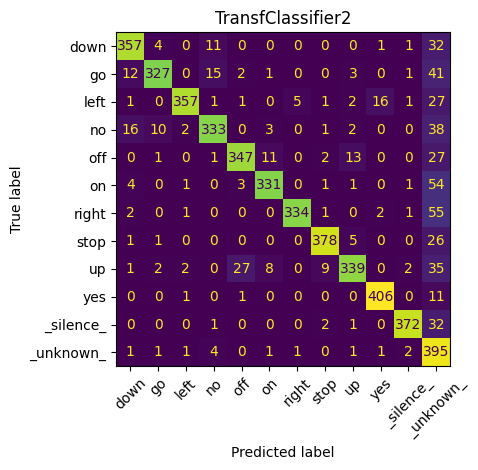

In [ ]:
results_TransfClassifier2, y_pred_class_TransfClassifier2 = model_results(model=model_TransfClassifier2, time_callback=time_callback_TransfClassifier2,
                                                                          model_label=filename_TransfClassifier2, model_type='transf_encoder_classifier',
                                                                          save=False)
results_TransfClassifier2

### Results TransfClassifier3

39/39 [==============================] - 2s 32ms/step
Results object saved as Others/TransfClassifier3_results.json


{'Model': 'TransfClassifier3',
 'Accuracy': 0.8593047034764826,
 'Precision': 0.8985493027310719,
 'Recall': 0.8593047034764826,
 'F-score': 0.8683986172195505,
 'Training time (s)': 1424.9380140304565,
 'Prediction time (s)': 2.4547181129455566,
 'Confusion matrix': [[346, 4, 0, 13, 0, 2, 0, 0, 1, 1, 1, 38],
  [10, 297, 0, 25, 2, 2, 0, 0, 1, 0, 2, 63],
  [1, 0, 354, 1, 1, 0, 2, 0, 0, 16, 1, 36],
  [12, 4, 2, 348, 0, 1, 0, 0, 3, 0, 0, 35],
  [0, 0, 3, 3, 351, 14, 0, 0, 5, 0, 0, 26],
  [1, 0, 0, 0, 11, 340, 0, 0, 0, 0, 0, 44],
  [0, 0, 4, 0, 0, 0, 329, 0, 0, 2, 0, 61],
  [2, 0, 1, 0, 4, 0, 0, 377, 3, 1, 0, 23],
  [2, 0, 7, 0, 54, 7, 0, 6, 294, 0, 2, 53],
  [0, 0, 5, 0, 0, 0, 0, 0, 0, 402, 0, 12],
  [0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 377, 27],
  [4, 2, 1, 4, 0, 7, 0, 0, 1, 0, 2, 387]]}

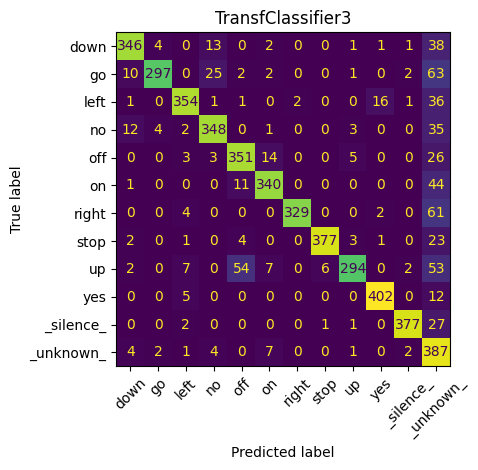

In [ ]:
results_TransfClassifier3, y_pred_class_TransfClassifier3 = model_results(model=model_TransfClassifier3, time_callback=time_callback_TransfClassifier3,
                                                                          model_label=filename_TransfClassifier3, model_type='transf_encoder_classifier',
                                                                          save=False)
results_TransfClassifier3

### Results summary

Formatting the results in a single table

In [ ]:
def results_summary(list_results, save=False):
  df = pd.DataFrame(list_results)
  df = df[['Model','Accuracy','F-score','Training time (s)','Prediction time (s)']]
  df = df.round(3)
  if save:
    df.to_csv(path_others + 'Final results.csv', index=False)
  return df

list_results = [results_AttRNN,
                results_ResAttRNN1, results_ResAttRNN2, results_ResAttRNN3, results_ResAttRNN4, results_ResAttRNN5,
                results_TransfClassifier1, results_TransfClassifier2, results_TransfClassifier3]
final_results = results_summary(list_results, save=False)
final_results

,Model,Accuracy,F-score,Training time (s),Prediction time (s)
0,AttRNN,0.926,0.929,197.843,5.202
1,ResAttRNN1,0.914,0.919,347.532,3.805
2,ResAttRNN2,0.920,0.925,412.177,5.290
3,ResAttRNN3,0.916,0.921,337.089,3.436
4,ResAttRNN4,0.939,0.942,1812.579,4.664
5,ResAttRNN5,0.933,0.936,1134.019,5.266
6,TransfClassifier1,0.847,0.861,1886.221,4.243
7,TransfClassifier2,0.874,0.883,3279.944,2.990
8,TransfClassifier3,0.859,0.868,1424.938,2.455


In [ ]:
# LaTeX format
final_results.to_latex(index=False, float_format='{:.3f}'.format)

'\\begin{tabular}{lrrrr}\n\\toprule\nModel & Accuracy & F-score & Training time (s) & Prediction time (s) \\\\\n\\midrule\nAttRNN & 0.926 & 0.929 & 197.843 & 5.202 \\\\\nResAttRNN1 & 0.914 & 0.919 & 347.532 & 3.805 \\\\\nResAttRNN2 & 0.920 & 0.925 & 412.177 & 5.290 \\\\\nResAttRNN3 & 0.916 & 0.921 & 337.089 & 3.436 \\\\\nResAttRNN4 & 0.939 & 0.942 & 1812.579 & 4.664 \\\\\nResAttRNN5 & 0.933 & 0.936 & 1134.019 & 5.266 \\\\\nTransfClassifier1 & 0.847 & 0.861 & 1886.221 & 4.243 \\\\\nTransfClassifier2 & 0.874 & 0.883 & 3279.944 & 2.990 \\\\\nTransfClassifier3 & 0.859 & 0.868 & 1424.938 & 2.455 \\\\\n\\bottomrule\n\\end{tabular}\n'

### Checking misclassified examples

In [ ]:
def example_mismatch(predictions, id_desired_mismatch=0):

  # Getting the indices where there is a mismatch
  # This is a list of ids (each value tellms me where to locate the actual example)
  mismatched_indices = np.where(y_true_test != predictions)[0]

  # Getting the index of a specific mismatch from the array of mismatch indices
  index_mismatch = mismatched_indices[id_desired_mismatch]

  print(f'True label: {label_names[y_true_test[index_mismatch]]}')
  print(f'Prediction: {label_names[predictions[index_mismatch]]}')
  listen_example(sc_test, index_mismatch)

example_mismatch(predictions=y_pred_class_ResAttRNN4, id_desired_mismatch=10)

True label: down
Prediction: _unknown_


### Test with my own examples

In [ ]:
from scipy.io import wavfile
def my_own_audios_test(model):

  audio_folder = 'My audios'

  audio_files = [os.path.join(audio_folder, file) for file in os.listdir(audio_folder) if file.endswith(".wav")]

  # Function to load audio from file
  def load_audio(audio_path):
    sample_rate, audio_data = wavfile.read(audio_path)
    audio_data = audio_data.astype(np.float32)
    audio_data = audio_data[:, 0]

    # Clipping the audio to be maximum 16000 long
    if len(audio_data) > 16000:
      audio_data = audio_data[:16000]

    if b'down' in audio_path:
      label = np.int32(0)
    elif b'left' in audio_path:
      label = np.int32(2)
    elif b'stop' in audio_path:
      label = np.int32(7)
    return audio_data, label

  # Converting to tf.data.Dataset
  new_dataset = tf.data.Dataset.from_tensor_slices(audio_files)

  # Loading audio from file and add labels
  def load_audio_wrapper(audio_file):
    audio_data, label = tf.numpy_function(load_audio, [audio_file], [tf.float32, tf.int32])
    return audio_data, label

  new_dataset = new_dataset.map(load_audio_wrapper)

  # Printing the true labels and displaying the audios
  for audio, label in new_dataset:
    print('TRUE LABELS')
    print(f'True label: {label_names[label.numpy()]}')
    display.display(display.Audio(audio, rate=16000))
    print('\n')


  #--------------------------------------------------------------
  # Applying the preprocessing and predicting the labels
  print('\n\nPREDICTIONS')
  sc_test_own = wrap_preprocessing(reference_dataset = new_dataset,
                                   batch_size = 1,
                                   shuffle = False)

  predictions_own = model.predict(sc_test_own, steps=3)[:3]
  pred_labels_own = predictions_own.argmax(axis=1)
  for label in pred_labels_own:
    print(f'Prediction: {label_names[label]}')

my_own_audios_test(model_ResAttRNN3)

TRUE LABELS
True label: down




TRUE LABELS
True label: left




TRUE LABELS
True label: stop






PREDICTIONS
3/3 [==============================] - 4s 19ms/step
Prediction: down
Prediction: left
Prediction: stop
